<img src="images/GAlogo.png" style="float: left; margin: 15px; height: 100px">

# CAPSTONE PROJECT
## US TORNADOES AND HOW TO PREDICT THEIR MAGNITUDE
### PART 3

# Summary of the work done in part 1:

- Part 1 was about a first glance at the tornado data from the US National Weather Service (NWS). 500 tornadoes were analyzed over a period of just 5 months. EDA was performed and Logisitic regression as well as Random Forest were tested.
- As a reminder, our target is the tornado's Enhanced Fujita Scale. It ranges from EF0 to EF5, the latest being the most destructive. As this scale is based on the damage the tornado causes, and not on an accurate measure of wind speed, I chose classification models to predict it.
- The features are various tornado parameters linked to time and date it occured, its location, its characteristics, etc.
- All the models were fitted on a a train dataset, and validated with accuracy score on a test dataset.
- The baseline accuracy was: *0.624*.
- The best model was random forest, which hyperparmeters were optimized through thorough gridsearch. The obtained accuracy was: *0.768*. We therefore managed to improve our accuracy by about 14%.
- It is worth noting that on that subset of 500 tornadoes, none were registered as EF5 and only a few as EF4. All tornadoes with EF3 scale and higher were then gathered in a same class.


# Part 1 pending things:

- At the end of [part1 notebook](tornadoes_part1_project_introduction.ipynb), I was trying to compute two parameters from the range and compass azimuth of the beginning and end points of a tornado:
    - Length of its straight path.
    - Azimuth of its straight path, in degrees clockwise from North.<br><br>
- Since then, to understand better how the different tornado parameters are determined, I wrote an email to the meteorologist in charge of the data at the NOAA's National Centers for Environmental Information, Center for Weather and Climate. He sent me an exhaustive document (*NATIONAL WEATHER SERVICE INSTRUCTION 10-1605, MARCH 23, 2016, STORM DATA PREPARATION*) explaining in details how each parameter is entered in the database. Basically, there is not only one way, it depends on the tornado. For instance, longitude and latitude are entered either directly, and then the range and azimuth to a particular geographical point are computed, or the latest are measured and then longitude and latitude are derived from them. Regarding the magnitude, sometimes the narrative is enough to determine the damage, and therefore the EF scale, sometimes not. In that case, post-inspection is needed.<br><br>
- One of my issues in part 1 was that for some weak tornadoes, lat/long for beginning and end points were the same. It just means the tornado not lasted long. So the value entered for its straight path length should have been 0. In most cases it is not 0, and it is info they manually entered based on narrative or post-inspection. It means it is much more accurate to use in our models the value they entered for length, and not the one I derived.
- I want to introduce the azimuth as a new feature. My issue in part 1 is related to what I was explaining before: lat/long being the same for beginning and end points for some tornadoes produces NaN values for my azimuth. Now I know that when this is the case, it means the tornado was very short living and was almost stationary. I am therfore going to replace those NaNs by the median value.


# Importing more data:

- Storm event databases from 1950 until May this year were webscraped, imported as csv files and copied into my local PostgreSQL. The whole process is described in more details in the notebook [webscraping and postgresql save](tornadoes_part2_webscraping_posgres.ipynb)


# Outline of part 3:

> ### Data cleaning:
    - Do the data cleaning in a more efficient way by writing new functions
> ### EDA:
    - Redo EDA as many more tornadoes are now present. 
    - Try and find interesting new insights on the data!
    
> ### Modelling:
    - Redo classification modeling using Logistic Regression and Random Forest.
    - Try Recurrent Neural Network (RNN)!

> ### PCA
    - Principal component analysis for feature reduction.

> ### NLP 
    - Trying to predict the tornado's EF scale from extracted words of event narratives
    - Count Vectorizer, Lemmatization, TF-IDF

> ### Time series analysis
    - Analysing the seasonability and how the count of tornadoes evolve over time


# Packages import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import itertools

from sqlalchemy import create_engine
import requests
from bs4 import BeautifulSoup

import calendar
from datetime import datetime, date, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob, Word
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

Using TensorFlow backend.


In [2]:
# To avoid display of warnings in Jupyter Notebook:
# import warnings
# warnings.filterwarnings('ignore')

# Copying to DF all tornadoes from 2007 (when EF scale was introduced) to mid-2017

The webscraping, import and saving to local sql database is done in the separate notebook: <br>
[webscraping and postgresql save](tornadoes_part2_webscraping_posgres.ipynb)

In [3]:
# Creating engine connection to my local "storms" database, using sqlalchemy:
engine_local = create_engine('postgresql://localhost:5432/storms')

In [4]:
# Displaying the first 3 rows from the tornado table
sql_query = 'SELECT * FROM tornadoes_1950_mid2017 LIMIT 3' 
pd.read_sql(sql_query, engine_local)

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,195004,28,1445,195004,28,1445,None,10096222,OKLAHOMA,40.0,...,0.0,None,None,35.12,-99.2,35.17,-99.20,None,None,PUB
1,195004,29,1530,195004,29,1530,None,10120412,TEXAS,48.0,...,0.0,None,None,31.90,-98.6,31.73,-98.60,None,None,PUB
2,195007,5,1800,195007,5,1800,None,10104927,PENNSYLVANIA,42.0,...,0.0,None,None,40.58,-75.7,40.65,-75.47,None,None,PUB


In [5]:
# Checking that from 2007 we only have EF scale data:
sql_query = """
SELECT COUNT("TOR_F_SCALE"), "TOR_F_SCALE"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200701
GROUP BY "TOR_F_SCALE"
ORDER BY count DESC
"""
pd.read_sql(sql_query, engine_local)

,count,TOR_F_SCALE
0,7661,EF0
1,4822,EF1
2,1441,EF2
3,435,EF3
4,103,EF4
5,62,EFU
6,14,EF5
7,11,F1
8,8,F0
9,3,F2


We can notice the Fujita scale was still in place in January of 2017, though very few tornadoes were counted as such.
<br>Let's see if we take data from Feb of 2017 instead:

In [6]:
sql_query = """
SELECT COUNT("TOR_F_SCALE"), "TOR_F_SCALE"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702
GROUP BY "TOR_F_SCALE"
ORDER BY count DESC
"""
pd.read_sql(sql_query, engine_local)

,count,TOR_F_SCALE
0,7661,EF0
1,4822,EF1
2,1441,EF2
3,435,EF3
4,103,EF4
5,62,EFU
6,14,EF5


Now it's fine: only Enhanced Fujita scale magnitudes. Let's save this as a dataframe

In [41]:
# Saving the data from Feb 2007 until now (since the EF scale has been in place):
sql_query = """
SELECT * 
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702;
"""

raw_2007_2017 = pd.read_sql(sql_query, engine_local)

# Counting the number of tornadoes in each magnitude category:
raw_2007_2017.TOR_F_SCALE.value_counts()

EF0    7661
EF1    4822
EF2    1441
EF3     435
EF4     103
EFU      62
EF5      14
Name: TOR_F_SCALE, dtype: int64

- First we can see that the DF has the same counts as the sql query we did before. It's a good QC.
- We can also notice there is another magnitude which we had not yet encountered: EFU. It actually means the NWS could not identify the strength of the tornado from the data they have. Some of the reasons can be:
    - lack of description
    - tornado not easily accessible
    - no trackable damage because over a lake
<br>We could actually try and model EFU as a separate category. Let's NOT remove it for now.

In [8]:
raw_2007_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14538 entries, 0 to 14537
Data columns (total 51 columns):
BEGIN_YEARMONTH       14538 non-null int64
BEGIN_DAY             14538 non-null int64
BEGIN_TIME            14538 non-null int64
END_YEARMONTH         14538 non-null int64
END_DAY               14538 non-null int64
END_TIME              14538 non-null int64
EPISODE_ID            14538 non-null float64
EVENT_ID              14538 non-null int64
STATE                 14538 non-null object
STATE_FIPS            14538 non-null float64
YEAR                  14538 non-null int64
MONTH_NAME            14538 non-null object
EVENT_TYPE            14538 non-null object
CZ_TYPE               14538 non-null object
CZ_FIPS               14538 non-null int64
CZ_NAME               14538 non-null object
WFO                   14538 non-null object
BEGIN_DATE_TIME       14538 non-null object
CZ_TIMEZONE           14538 non-null object
END_DATE_TIME         14538 non-null object
INJURIES_DIRECT   

- Other features which were not present in the sample dataset presented in part 2 of the capstone project, are now available. Some which we will drop later.
- For now, let's just do the editing and analysis as we did in part 2, but making it more efficient with functions.

In [9]:
# Making another backup as an easily accessible csv:
# raw_2007_2017.to_csv('../../../../../../DATASETS/SavedData/capstone_project_raw_2007_2017.csv', index_label=False)

Somehow, I could not save the file as a csv because of a formatting error (codec...)

In [10]:
# Making a copy of the raw data:
tornado_2007_2017 = raw_2007_2017.copy()

In [11]:
tornado_2007_2017.columns

Index([u'BEGIN_YEARMONTH', u'BEGIN_DAY', u'BEGIN_TIME', u'END_YEARMONTH',
       u'END_DAY', u'END_TIME', u'EPISODE_ID', u'EVENT_ID', u'STATE',
       u'STATE_FIPS', u'YEAR', u'MONTH_NAME', u'EVENT_TYPE', u'CZ_TYPE',
       u'CZ_FIPS', u'CZ_NAME', u'WFO', u'BEGIN_DATE_TIME', u'CZ_TIMEZONE',
       u'END_DATE_TIME', u'INJURIES_DIRECT', u'INJURIES_INDIRECT',
       u'DEATHS_DIRECT', u'DEATHS_INDIRECT', u'DAMAGE_PROPERTY',
       u'DAMAGE_CROPS', u'SOURCE', u'MAGNITUDE', u'MAGNITUDE_TYPE',
       u'FLOOD_CAUSE', u'CATEGORY', u'TOR_F_SCALE', u'TOR_LENGTH',
       u'TOR_WIDTH', u'TOR_OTHER_WFO', u'TOR_OTHER_CZ_STATE',
       u'TOR_OTHER_CZ_FIPS', u'TOR_OTHER_CZ_NAME', u'BEGIN_RANGE',
       u'BEGIN_AZIMUTH', u'BEGIN_LOCATION', u'END_RANGE', u'END_AZIMUTH',
       u'END_LOCATION', u'BEGIN_LAT', u'BEGIN_LON', u'END_LAT', u'END_LON',
       u'EPISODE_NARRATIVE', u'EVENT_NARRATIVE', u'DATA_SOURCE'],
      dtype='object')

#  Cleaning and transformation of raw data

## Functions from part 2 of capstone, to transform location data:

In [12]:
# Transforming the function in part 1 into an easier-to-read dictionnary
# For each compass direction corresponds a clockwise angle in degrees from North
# This dictionnary will be used to convert the azimuths variables from the tornado dataframe
compassdir2degrees = {'N': 0., 'NNE': 22.5, 'NE': 45., 'ENE': 67.5, 'E': 90., 'ESE': 112.5, 
                      'SE': 135., 'SSE': 157.5, 'S': 180., 'SSW': 202.5, 'SW': 225., 
                      'WSW': 247.5, 'W': 270., 'WNW': 292.5, 'NW': 315., 'NNW': 337.5}


def compute_Az_AvLat_AvLon_fromLatLong(df, xA='BEGIN_LON', yA='BEGIN_LAT', xB='END_LON',
                                       yB='END_LAT', outMeanLat='Mean_Lat', 
                                       outMeanLon='Mean_Lon', outAz='Azimuth'):
    '''Takes a tornado dataframe in input, with geographical coordinates of beginning and end 
    points.
    Returns the dataframe with 3 new features: 
    direction the tornado headed from North (azimuth of its rectiligne path)
    average latitude
    average longitude'''
    
    # New features with average latitude and longitude of the tornado path:
    LAT = (df[yA]+df[yB])/2
    LON = (df[xA]+df[xB])/2
    df[outMeanLat] = np.round(LAT,4)
    df[outMeanLon] = np.round(LON,4)

    # Approximate Earth radius in miles:
    R = 3959
    
    # Coordinates differences converted to radians:
    diffLON = np.radians(df[xB] - df[xA])
    diffLAT = np.radians(df[yB] - df[yA])
      
    # Azimuth computed from trigonometry (arctan2 allows getting the angle in range (-pi,pi) 
    # instead of (-pi/2,pi/2) like with conventional arctan):
    AZ = pd.Series(index=diffLON.index)
    for i in range(len(diffLON)):
        if diffLAT[i]==0 and diffLON[i]==0:
            AZ[i] = np.nan
        else:
            AZ[i] = np.degrees(np.arctan2(diffLON[i],diffLAT[i]))
    
    # Saving azimuth into new column:
    df[outAz] = np.round(AZ,2)

    # Let's make the North as the middle of the range => angles from ]-pi;pi] instead of [0;2pi[
    df[outAz] = df[outAz].map(lambda x: x-360 if x>180 else x)

    return df

## Function to convert the target into integers
This will be used for plotting and for numerical analyses like correlations

In [13]:
def convertEFtonb(x):
    '''Converts an EF scale string to integer of the corresponding number'''
    if x=='EF0' or x=='EFU': return 0
    elif x=='EF1': return 1
    elif x=='EF2': return 2
    elif x=='EF3': return 3
    elif x=='EF4': return 4
    elif x=='EF5': return 5
    else: return np.nan

## New function for plotting windrose

In [14]:
def plot_windrose(df, EFscale='TOR_F_SCALE', Azimuth='Azimuth', TorYears='2007-2017'):
    '''Plots a windrose diagram from the azimuth and EF scales of a tornado dataframe'''
    
    # Somehow, the packages seems to unload sometimes, when imported upfront. 
    # The solution I found was to import them each time the function is called.
    from windrose import WindroseAxes, plot_windrose
    
    dfwindroseAzim = pd.DataFrame({'speed':list(df[EFscale].map(convertEFtonb).values), 
                                   'direction':list(df[Azimuth].values)}).reset_index(drop=True)

    # Radial grids must be strictly positive for the windrose display:
    dfwindroseAzim.direction = dfwindroseAzim.direction.map(lambda x: 0.001 if x==0 
                                                            else 360+x if x<0 else x)

    sns.set(font_scale=1.3)
    plot_windrose(dfwindroseAzim, kind='bar', bins=np.arange(-0.5,5.5,1), edgecolor='black')

    plt.title("Distribution of the {} tornadoes' heading (Blue to Red for weak to strong\
              magnitudes)".format(TorYears))
    plt.legend("lower right")
    plt.show()

## New function for transforming date and time data

- Excerpt taken from the National Severe Storm Laboratory http://www.nssl.noaa.gov/education/svrwx101/tornadoes/:
<br>"Tornado season usually refers to the time of year the U.S. sees the most tornadoes. The peak “tornado season” for the Southern Plains is during May into early June. On the Gulf coast, it is earlier during the spring. In the northern plains and upper Midwest, tornado season is in June or July. But, remember, tornadoes can happen at any time of year. Tornadoes can also happen at any time of day or night, but most tornadoes occur between 4–9 p.m."
- The probability of having a tornado and the probability of having a strong tornado are higher in the months from April to July. Later, I am going to confirm this by doing Time Series Analysis.
- Because of this annual seasonability, I am going to transform the dates into ordinals. The idea behind this is that a specific day of the year would imply more or less a tornado to be strong or not.

In [57]:
def computeduration(df, beginDT='BEGIN_DATE_TIME', endDT='END_DATE_TIME'):
    '''Takes a tornado dataframe in input, with dates and times of beginning and end of a tornado,
    in text format.
    Converts them into datatime format.
    Computes the duration in minutes and returns it as new column
    Computes the average date and average time, 
    Computes the day of the year, and time in floating format, and returns them as new columns'''

    # Changing to datetime format:
    df[beginDT] = pd.to_datetime(df[beginDT])
    df[endDT] = pd.to_datetime(df[endDT])
    
    # Computes the duration:
    df['Duration'] =  df[endDT] - df[beginDT]
    # Converting to minutes from seconds:
    df['Duration'] = df.Duration.map(lambda x: int(round(x.total_seconds()/60.)))
    
    # Computing the average date and time of a tornado event:
    df['AverageDate'] = pd.to_datetime(df[beginDT] + (df[endDT] - df[beginDT])/2)
    df['AverageTime'] = df['AverageDate']
    
    def dayoftheyear(x):
        '''converts a timestamp object into day of the year, taking leap years into account'''
        dayYear = x.timetuple().tm_yday
        # Feb 28 corresponds to year day 31+28=59
        if calendar.isleap(x.year) and dayYear<=59:
            return dayYear
        # For dates superior or equal to Feb 29, for leap years, returns the value-1 for a number
        # to always correspond to the same date for any year
        elif calendar.isleap(x.year) and dayYear>59:
            return dayYear - 1
        # For non leap years:
        else:
            return dayYear
    # Converting date to day of the year:
    df['AverageDate'] = df['AverageDate'].map(dayoftheyear)
    
    # Converting time to float from Timestamp object:
    df['AverageTime'] = df['AverageTime'].map(lambda x: x.time())
    df['AverageTime'] = df['AverageTime'].map(lambda x: x.hour) \
    + df['AverageTime'].map(lambda x: round((x.minute*100/60.)/100., 2)) \
    + df['AverageTime'].map(lambda x: round((x.second*100/60.)/10000., 4))
    
    return df

In [58]:
# Testing the previous function with a small subset of data:
testdf = raw_2007_2017[['BEGIN_DATE_TIME', 'END_DATE_TIME']].head()

computeduration(testdf)

,BEGIN_DATE_TIME,END_DATE_TIME,Duration,AverageDate,AverageTime
0,2008-07-27 15:51:00,2008-07-27 15:52:00,1,208,15.855
1,2008-07-27 16:15:00,2008-07-27 16:16:00,1,208,16.255
2,2008-07-27 15:34:00,2008-07-27 15:35:00,1,208,15.575
3,2007-05-06 15:40:00,2007-05-06 15:43:00,3,126,15.685
4,2007-07-02 17:30:00,2007-07-02 17:35:00,5,183,17.535


## New function for transformation of cost features:

From the official description of Storm Data Format:  
- Damage_property = The estimated amount of damage to property incurred by the weather event in dollars. 
- Damage_crops = The estimated amount of damage to crops incurred by the weather event in dollars.   
- Format examples: 
    * 10.00K = 10,000
    * 10.00M = 10,000,000

In [59]:
def convertcost_tointeger(cost):
    '''From a cost in text format in format 'nb'.00'letter' where letter = K or M or B
    Returns a cost as integer'''
    if pd.isnull(cost): return 0
    elif 'K' in cost: return int(round(float(cost[:-2]) * 10**3))
    elif 'M' in cost: return int(round(float(cost[:-2]) * 10**6))
    elif 'B' in cost: return int(round(float(cost[:-2]) * 10**9))
    else: return np.nan

In [60]:
# Testing the previous function with a small subset of data:
testdf2 = raw_2007_2017[['DAMAGE_PROPERTY', 'DAMAGE_CROPS']][67:74]

testdf2['PropertyDamageCost'] = testdf2.DAMAGE_PROPERTY.map(convertcost_tointeger)
testdf2['CropsDamageCost'] = testdf2.DAMAGE_CROPS.map(convertcost_tointeger)
testdf2

,DAMAGE_PROPERTY,DAMAGE_CROPS,PropertyDamageCost,CropsDamageCost
67,0.00K,0.00K,0,0
68,4.00K,0.00K,4000,0
69,2.50K,0.00K,2500,0
70,1.50M,0.00K,1500000,0
71,100.00K,0.00K,100000,0
72,3.50M,None,3500000,0
73,20.00K,0.00K,20000,0


## New dictionary for transforming the state names into shorter abbreviations:

FIPS = Federal Information Processing Standardisation

In this part, I am going to automatically retrieve the info I need from a table in a Wikipedia page and convert it to a dictionnary:

In [61]:
# Investigating the state FIPS values:
raw_2007_2017['STATE_FIPS'].unique()

array([ 19.,  20.,  12.,  46.,  28.,  39.,  45.,  18.,  38.,  27.,  31.,
        48.,   1.,   6.,  22.,   5.,  26.,  35.,  17.,  29.,  40.,  24.,
         8.,  21.,  47.,  55.,  42.,  16.,  37.,  13.,  30.,  41.,  56.,
        49.,  25.,  51.,   9.,  54.,  36.,  23.,  99.,  15.,   4.,  53.,
        33.,  50.,  44.,  32.,  34.,  10.,  11.])

In [62]:
# Number 99 does not appear in the official FIPS table, let's see to what it corresponds to:
raw_2007_2017[raw_2007_2017['STATE_FIPS']==99][['STATE_FIPS','STATE']].head(2)

,STATE_FIPS,STATE
1165,99.0,PUERTO RICO
4343,99.0,PUERTO RICO


In [63]:
# Link to the FIPS table:
link = "https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code"
response = requests.get(link)
html = response.text

# Making a soup out of the html and creating the list of FIPS table rows:
soup = BeautifulSoup(html, "lxml")
listofFIPSrows = soup.findAll("tr")
    
# Creating a dictionary with the correspondances between state FIPS number and 
# state name abbreviation (eg: 'AL' for 1, 'AK' for 2, etc.):
fips_to_state = {}
for element in listofFIPSrows[1:75]:
    # Some FIPS numbers in the table do not have associated abbreviation, we therefore
    # do not use those rows:
    if str(element).split('<td>')[2][:2] != '</':
        fips_to_state[int(str(element).split('<td>')[3][:2])] = str(element).split('<td>')[2][:2]

# Puerto Rico is registered as number 99 in the tornado data:
fips_to_state[99] = 'PR'

print "FIPS number and state abreviation dictionary:\n", fips_to_state

FIPS number and state abreviation dictionary:
{1: 'AL', 2: 'AK', 4: 'AZ', 5: 'AR', 6: 'CA', 8: 'CO', 9: 'CT', 10: 'DE', 11: 'DC', 12: 'FL', 13: 'GA', 15: 'HI', 16: 'ID', 17: 'IL', 18: 'IN', 19: 'IA', 20: 'KS', 21: 'KY', 22: 'LA', 23: 'ME', 24: 'MD', 25: 'MA', 26: 'MI', 27: 'MN', 28: 'MS', 29: 'MO', 30: 'MT', 31: 'NE', 32: 'NV', 33: 'NH', 34: 'NJ', 35: 'NM', 36: 'NY', 37: 'NC', 38: 'ND', 39: 'OH', 40: 'OK', 41: 'OR', 42: 'PA', 44: 'RI', 45: 'SC', 46: 'SD', 47: 'TN', 48: 'TX', 49: 'UT', 50: 'VT', 51: 'VA', 53: 'WA', 54: 'WV', 55: 'WI', 56: 'WY', 60: 'AS', 64: 'FM', 66: 'GU', 68: 'MH', 69: 'MP', 70: 'PW', 72: 'PR', 74: 'UM', 78: 'VI', 99: 'PR'}


In [64]:
# Testing the previous dictionary application with a small subset of data:
testdf3 = raw_2007_2017[['STATE_FIPS','STATE']][784:790]

testdf3['State'] = testdf3['STATE_FIPS'].map(lambda x: fips_to_state[x])
testdf3

,STATE_FIPS,STATE,State
784,31.0,NEBRASKA,NE
785,20.0,KANSAS,KS
786,20.0,KANSAS,KS
787,48.0,TEXAS,TX
788,31.0,NEBRASKA,NE
789,20.0,KANSAS,KS


## Function to plot confusion matrices

In [65]:
# Function to plot the confusion matrices in a nicer and more interpretable way:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, 
                          xlab='Predicted magnitude', ylab='True magnitude'):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.show()

## Outlier analysis

In [66]:
# Further analysis shows an outlier with TOR_LENGTH of 100 miles.
raw_2007_2017[tornado_2007_2017.TOR_LENGTH>50].head().T

,13339
BEGIN_YEARMONTH,201607
BEGIN_DAY,8
BEGIN_TIME,1656
END_YEARMONTH,201607
END_DAY,8
END_TIME,1703
EPISODE_ID,108385
EVENT_ID,649308
STATE,MICHIGAN
STATE_FIPS,26


So this tornado lasted only about 7 minutes and was a very weak one. It is impossible it traveled 100 miles. The straight path length was then entered wrongly.
<br>We will remove that row

## Column editions:

Plot before imputing NaN azimuth values:


/Users/Yves/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


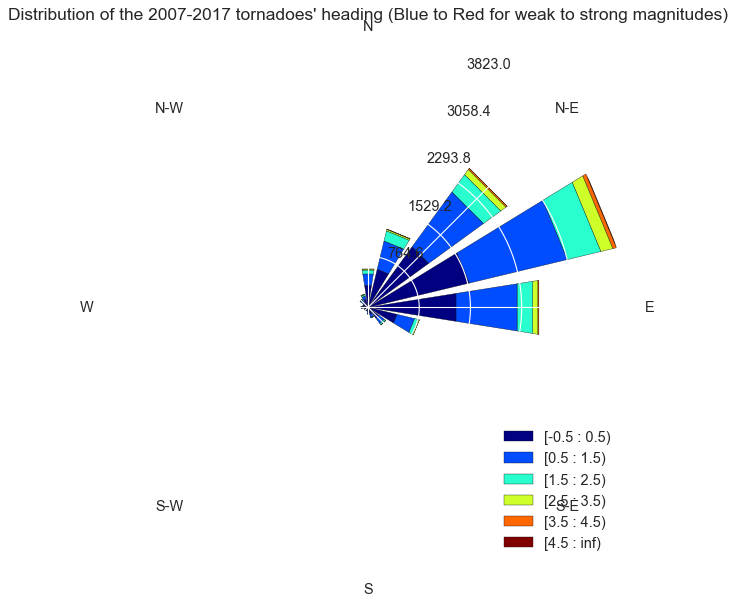

The median azimuth of the tornados' straight paths is: 64.12 degrees.
We are replacing the computed NaN azimuths to this value.
nPlot after imputing NaN azimuth values:


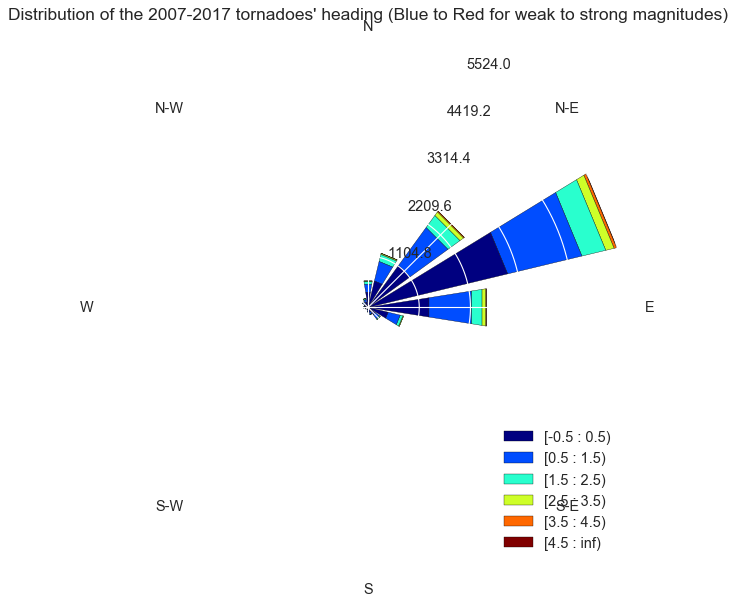

In [67]:
# Removing unnecessary columns:
tornado_2007_2017 = tornado_2007_2017.drop(['EVENT_ID', 'EPISODE_ID', 
                                            'EVENT_TYPE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 
                                            'FLOOD_CAUSE', 
                                            'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 
                                            'DATA_SOURCE', 'CATEGORY'], axis=1)

# Adding 3 new columns with the duration and the average year-date and time: 
tornado_2007_2017 = computeduration(tornado_2007_2017)

# Removing original columns related to date and time:
tornado_2007_2017.drop(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH', 'END_DAY',
                        'END_TIME', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME', 'YEAR',
                        'MONTH_NAME'], axis=1, inplace=True)

# Gathering direct and indirect deaths, and injuries:
tornado_2007_2017['Deaths'] = tornado_2007_2017.DEATHS_DIRECT + tornado_2007_2017.DEATHS_INDIRECT
tornado_2007_2017['Injuries'] = tornado_2007_2017.INJURIES_DIRECT +\
                                tornado_2007_2017.INJURIES_INDIRECT
tornado_2007_2017.drop(['DEATHS_DIRECT','DEATHS_INDIRECT','INJURIES_DIRECT','INJURIES_INDIRECT'],
                       axis=1, inplace=True)

# Adds 3 new columns average latitude, longitude and azimuth of tornado's path:
tornado_2007_2017 = compute_Az_AvLat_AvLon_fromLatLong(tornado_2007_2017)

# Plots the windrose before imputing values for stationary tornadoes:
print "Plot before imputing NaN azimuth values:"
plot_windrose(tornado_2007_2017)

# Filling the azimuth NaN values with median:
print "The median azimuth of the tornados' straight paths is:", \
      tornado_2007_2017['Azimuth'].median(), "degrees."
print "We are replacing the computed NaN azimuths to this value."
tornado_2007_2017.Azimuth.fillna(tornado_2007_2017['Azimuth'].median(), inplace=True)

# Plots the windrose after imputing values for stationary tornadoes:
print "nPlot after imputing NaN azimuth values:"
plot_windrose(tornado_2007_2017)

# Converting the state FIPS numbers into state abbreviations easily recognizable:
tornado_2007_2017['State'] = tornado_2007_2017['STATE_FIPS'].map(lambda x: fips_to_state[x])

# Removing columns related to location:
tornado_2007_2017.drop(['BEGIN_RANGE', 'BEGIN_AZIMUTH', 'END_RANGE', 'END_AZIMUTH', 
                        'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 
                        'CZ_NAME', 'CZ_TYPE', 'CZ_FIPS', 'WFO', 'STATE_FIPS', 'STATE', 
                        'BEGIN_LOCATION', 'END_LOCATION', 
                        'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME',
                        'TOR_OTHER_WFO'],
                       axis=1, inplace=True)

# Converting the cost columns into integer numbers:
tornado_2007_2017['PropertyDamageCost'] = \
tornado_2007_2017.DAMAGE_PROPERTY.map(convertcost_tointeger)
tornado_2007_2017['CropsDamageCost'] = tornado_2007_2017.DAMAGE_CROPS.map(convertcost_tointeger)

# Removing old columns related to costs:
tornado_2007_2017.drop(['DAMAGE_PROPERTY', 'DAMAGE_CROPS'], axis=1, inplace=True)

# Replacing spaces by underscores in the SOURCE feature:
tornado_2007_2017.SOURCE = tornado_2007_2017.SOURCE.map(lambda x: x.replace(' ', '_'))

# Removing tornado with outlier TOR_LENGTH=100:
tornado_2007_2017 = tornado_2007_2017[tornado_2007_2017.TOR_LENGTH<50]

- As we had noted in our small subset, most tornadoes travel NNE. 
- What we can note with more tornadoes is that the distribution seems very regular. And the magnitudes seem distributed evenly across the different directions. This means the azimuth may not bring much to our predictions of the EF scale.

In [68]:
# Displaying our new "cleaned" dataframe for the first 9 tornadoes
tornado_2007_2017.head(9).T

,0,1,2,3,4,5,6,7,8
SOURCE,Public,Law_Enforcement,Trained_Spotter,Law_Enforcement,Broadcast_Media,Storm_Chaser,NWS_Storm_Survey,NWS_Storm_Survey,Public
TOR_F_SCALE,EF0,EF0,EF1,EF0,EF0,EF0,EF0,EF2,EF1
TOR_LENGTH,0.27,0.2,0.29,1.43,1.38,2.77,0.55,1.5,0.2
TOR_WIDTH,20,20,100,50,20,100,30,300,50
Duration,1,1,1,3,5,9,1,0,0
AverageDate,208,208,208,126,183,111,152,105,105
AverageTime,15.855,16.255,15.575,15.685,17.535,18.875,11.925,6.25,9.17
Deaths,0,0,0,0,0,0,0,0,0
Injuries,0,0,0,0,0,0,0,0,0
Mean_Lat,41.7345,41.6694,41.7892,37.2945,26.72,43.683,24.6658,30.53,29.72


Now I have a good feature matrix. I will later (probably in part 4 :)) create a pipeline which encapsulates the whole pre-processing steps.

# EDA

I had done in part 2 extensive EDA, but only on a subset of 500 tornadoes. Let's redo the main analyses, and some more!

In [69]:
# First grouping by the tornado's magnitudes:
groupEFscale = tornado_2007_2017.groupby(by='TOR_F_SCALE')

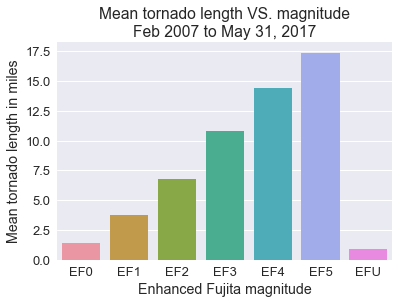

In [70]:
# Let's plot mean tornado length according to the magnitude:
plt.figure(figsize=(6,4))
sns.set(font_scale=1.3)
plt.title("Mean tornado length VS. magnitude\nFeb 2007 to May 31, 2017")
sns.barplot(groupEFscale.groups.keys(), groupEFscale.TOR_LENGTH.mean())
plt.xlabel("Enhanced Fujita magnitude")
plt.ylabel("Mean tornado length in miles")
plt.show()

- There is a clear correlation between the magnitude and the tornado length
- The unidentified tornadoes have high chance of actually being week EF0 tornadoes

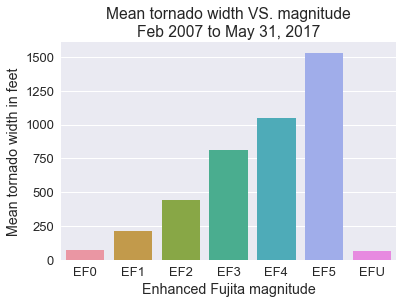

In [71]:
plt.figure(figsize=(6,4))
plt.title("Mean tornado width VS. magnitude\nFeb 2007 to May 31, 2017")
sns.barplot(groupEFscale.groups.keys(), groupEFscale.TOR_WIDTH.mean())
plt.xlabel("Enhanced Fujita magnitude")
plt.ylabel("Mean tornado width in feet")
plt.show()

- Same observations as for the length

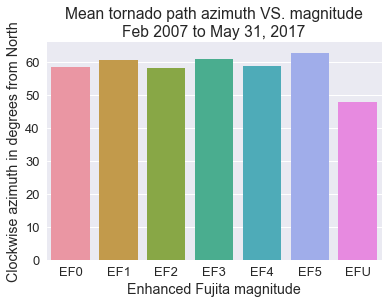

In [72]:
plt.figure(figsize=(6,4))
plt.title("Mean tornado path azimuth VS. magnitude\nFeb 2007 to May 31, 2017")
sns.barplot(groupEFscale.groups.keys(), groupEFscale.Azimuth.mean())
plt.xlabel("Enhanced Fujita magnitude")
plt.ylabel("Clockwise azimuth in degrees from North")
plt.show()

Now this is interesting, the azimuth of the tornado seems very similar between the different tornado strengths.

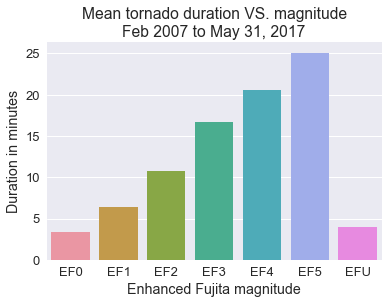

In [73]:
plt.figure(figsize=(6,4))
plt.title("Mean tornado duration VS. magnitude\nFeb 2007 to May 31, 2017")
sns.barplot(groupEFscale.groups.keys(), groupEFscale.Duration.mean())
plt.xlabel("Enhanced Fujita magnitude")
plt.ylabel("Duration in minutes")
plt.show()

Magnitude of a tornado is strongly linked to its duration

- The pattern of the duration and length vs magnitude distributions seem very similar.
- I suspect a strong correlation. Let us verify this with a new scatter plot

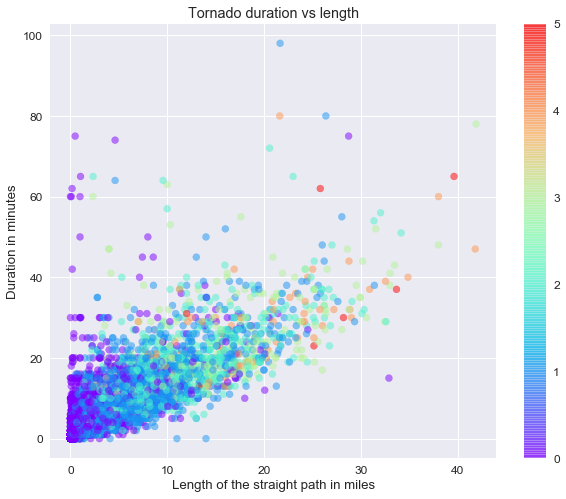

In [74]:
plt.figure(figsize=(10,8))
sns.set(font_scale=1.2)
plt.scatter(tornado_2007_2017.TOR_LENGTH, tornado_2007_2017.Duration, alpha=0.5,\
            c=tornado_2007_2017.TOR_F_SCALE.map(convertEFtonb), cmap='rainbow')
plt.title('Tornado duration vs length')
plt.colorbar()
plt.xlabel('Length of the straight path in miles')
plt.ylabel('Duration in minutes')
plt.show()

- The two features seem indeed to be correlated. 
- This is quite normal as the ratio of length by the duration should correspond to the average travel velocity of the tornado. However this is true only in a perfect case where the tornado would travel on a straight line, which is obviously very unlikely to occur in real weather conditions.
- What this correlation actually represents is more the average projected velocity of the tornado to the straight line passing through its beginning and end points.
- As expected, the colored points tell us that weaker tornadoes are both shorter and last less (purple points have a higher concentration close to the graph's origin). But surprisingly to me, I was expecting a bit less randomness in the distribution of colors. For example, even though most EF1 and EF2 tornadoes do not last long and are relatively short, some actually last quite a long time. Then again meteorology is not a straight and exact science!

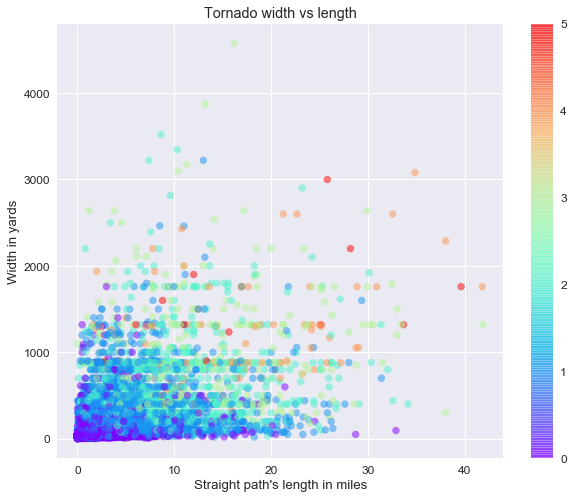

In [75]:
plt.figure(figsize=(10,8))
sns.set(font_scale=1.2)
plt.scatter(tornado_2007_2017.TOR_LENGTH, tornado_2007_2017.TOR_WIDTH, alpha=0.5,\
            c=tornado_2007_2017.TOR_F_SCALE.map(convertEFtonb), cmap='rainbow')
plt.title('Tornado width vs length')
plt.colorbar()
plt.xlabel("Straight path's length in miles")
plt.ylabel("Width in yards")
plt.show()

- The correlation is less obvious here.
- However, the color distribution is more segmented: weaker tornadoes are likely to be thinner for instance

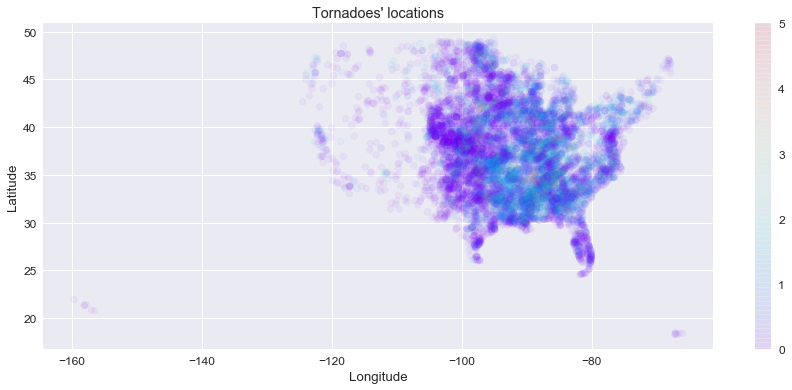

In [76]:
plt.figure(figsize=(15,6))
sns.set(font_scale=1.2)
plt.scatter(tornado_2007_2017.Mean_Lon, tornado_2007_2017.Mean_Lat, alpha=0.05,\
            c=tornado_2007_2017.TOR_F_SCALE.map(convertEFtonb), cmap='rainbow')
plt.title("Tornadoes' locations")
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

- It is well known that tornadoes are more frequent in the "tornado alley", which is the central region in the US corresponding to the Great plains. This is clearly visible in the map above. 
- The map display needs some extra work in order to distinguish better the stronger tornadoes and where the occur most.
- I will spend more time later trying to do better displays in Tableau

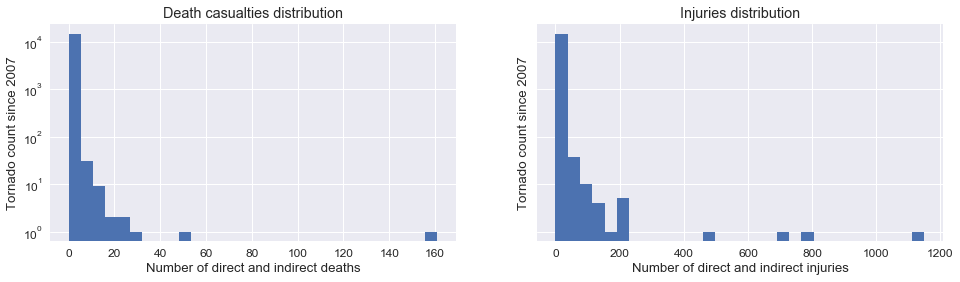

In [77]:
# Checking death casualties and injuries, taking both direct and indirect ones together:
fig, ax = plt.subplots(1,2, figsize=(16,4), sharey=True)
tornado_2007_2017.Deaths.hist(bins=30, log=True, ax=ax[0])
tornado_2007_2017.Injuries.hist(bins=30, log=True, ax=ax[1])
ax[0].set_title("Death casualties distribution")
ax[0].set_xlabel("Number of direct and indirect deaths")
ax[0].set_ylabel("Tornado count since 2007")
ax[1].set_title("Injuries distribution")
ax[1].set_xlabel("Number of direct and indirect injuries")
ax[1].set_ylabel("Tornado count since 2007")
plt.show()

- Just a few tornadoes are actually deadly or cause harm (distributions are highly postively skewed -> let's not forget the scale of the above plots is logarithmic)
- The factors which influence if a tornado is life threatening or not are:
    * its magnitude
    * where it is located
    * the quality of the housing
    * the time it occurs
    * accuracy of the weather predictions

To support those notes, let's do the same graphs, but dividing into the different tornado magnitudes:

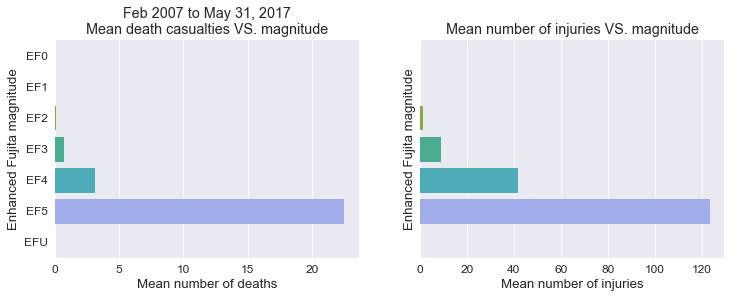

In [78]:
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
sns.barplot(groupEFscale.Deaths.mean(), groupEFscale.groups.keys(), orient='h', ax=ax[0])
sns.barplot(groupEFscale.Injuries.mean(), groupEFscale.groups.keys(), orient='h', ax=ax[1])
ax[0].set_title("Feb 2007 to May 31, 2017\nMean death casualties VS. magnitude")
ax[0].set_ylabel("Enhanced Fujita magnitude")
ax[0].set_xlabel("Mean number of deaths")
#fig.subplots_adjust(wspace = 1)
ax[1].set_title("Mean number of injuries VS. magnitude")
ax[1].set_ylabel("Enhanced Fujita magnitude")
ax[1].set_xlabel("Mean number of injuries")
plt.show()

This is really interesting (even though quite intuitive). It shows that:
- The stonger the tornado, the higher number of deaths and injuries
- Over the span of 10 years, EF0 and EF1 tornadoes have actually accounted for 0 death.
- EF5 tornadoes are very rare (14 in the last 10 years), but are life threatening.
- EFU tornadoes, which refer to the ones for which the NWS could not identify the magnitude based on the available data, do not register any deaths nor injuries. There are very likely to actually be EF0 (or EF1) tornadoes.

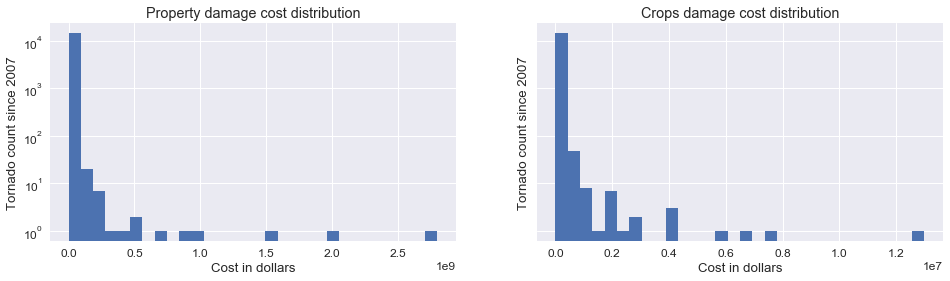

In [79]:
# Checking property and crops damage costs:
fig, ax = plt.subplots(1,2, figsize=(16,4), sharey=True)
tornado_2007_2017.PropertyDamageCost.hist(bins=30, log=True, ax=ax[0])
tornado_2007_2017.CropsDamageCost.hist(bins=30, log=True, ax=ax[1])
ax[0].set_title("Property damage cost distribution")
ax[0].set_xlabel("Cost in dollars")
ax[0].set_ylabel("Tornado count since 2007")
ax[1].set_title("Crops damage cost distribution")
ax[1].set_xlabel("Cost in dollars")
ax[1].set_ylabel("Tornado count since 2007")
plt.show()

Very similar kind of distribution as the injuries and deaths. Quite expected (same observations could be made).
<br>Basically few tornadoes are costly, but when they are strong they can provoke huge costs to both properties and crops.

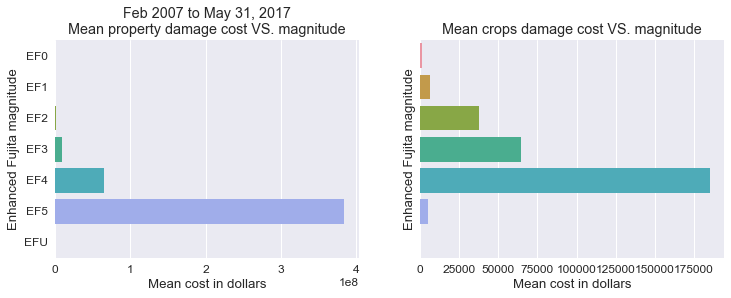

In [80]:
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
sns.barplot(groupEFscale.PropertyDamageCost.mean(), groupEFscale.groups.keys(), orient='h', ax=ax[0])
sns.barplot(groupEFscale.CropsDamageCost.mean(), groupEFscale.groups.keys(), orient='h', ax=ax[1])
ax[0].set_title("Feb 2007 to May 31, 2017\nMean property damage cost VS. magnitude")
ax[0].set_ylabel("Enhanced Fujita magnitude")
ax[0].set_xlabel("Mean cost in dollars")
#fig.subplots_adjust(wspace = 1)
ax[1].set_title("Mean crops damage cost VS. magnitude")
ax[1].set_ylabel("Enhanced Fujita magnitude")
ax[1].set_xlabel("Mean cost in dollars")
plt.show()

Quite unexpected findings! Why do EF5 tornadoes register low crops damage costs?
<br>Let's analyse what the EF5 tornadoes look like to try and understand

In [81]:
tornado_2007_2017[tornado_2007_2017["TOR_F_SCALE"]=='EF5']

,SOURCE,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth,State,PropertyDamageCost,CropsDamageCost
1132,NWS_Storm_Survey,EF5,25.80,3000.0,62,124,20.570,11,63,37.5088,-99.3566,12.67,KS,250000000,0
1472,NWS_Storm_Survey,EF5,15.64,1235.0,26,145,16.050,9,50,42.5612,-92.7081,88.06,IA,75000000,75000
6182,NWS_Storm_Survey,EF5,33.66,1320.0,37,117,17.625,25,0,34.5620,-85.7681,50.84,AL,0,0
6361,NWS_Storm_Survey,EF5,10.98,1320.0,12,117,14.900,0,0,34.1284,-88.2766,64.77,MS,100000,0
6751,NWS_Storm_Survey,EF5,8.80,1600.0,20,142,16.830,161,1150,37.0552,-94.4903,90.57,MO,2800000000,0
7547,NWS_Storm_Survey,EF5,39.60,1760.0,65,144,15.375,7,112,35.5845,-97.9920,64.53,OK,0,0
7595,NWS_Storm_Survey,EF5,6.05,1320.0,6,117,14.750,16,37,34.0673,-88.4025,62.84,MS,2500000,0
7599,NWS_Storm_Survey,EF5,16.95,1760.0,17,117,14.605,27,0,34.3738,-87.6582,63.73,AL,50000000,0
7749,NWS_Storm_Survey,EF5,25.14,1320.0,23,117,14.275,18,100,34.2076,-87.9668,60.29,AL,160000000,0
7790,NWS_Storm_Survey,EF5,28.19,2200.0,30,117,15.000,14,0,34.5413,-87.3181,63.81,AL,40000000,0


Let's check in the original database that all the cost values were computed correctly:

In [82]:
sql_query = """
SELECT "BEGIN_DATE_TIME", "END_DATE_TIME", "STATE", "DAMAGE_PROPERTY", "DAMAGE_CROPS",
       "INJURIES_DIRECT", "INJURIES_INDIRECT", "DEATHS_DIRECT", "DEATHS_INDIRECT", 
       "SOURCE", "TOR_F_SCALE"
FROM tornadoes_1950_mid2017 
WHERE "TOR_F_SCALE" = 'EF5'
ORDER BY "DEATHS_DIRECT" DESC
"""
pd.read_sql(sql_query, engine_local)

,BEGIN_DATE_TIME,END_DATE_TIME,STATE,DAMAGE_PROPERTY,DAMAGE_CROPS,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,SOURCE,TOR_F_SCALE
0,22-MAY-11 16:40:00,22-MAY-11 17:00:00,MISSOURI,2.80B,0.00K,1150,0,158,3,NWS Storm Survey,EF5
1,27-APR-11 14:28:00,27-APR-11 14:45:00,ALABAMA,50.00M,0.00K,0,0,27,0,NWS Storm Survey,EF5
2,27-APR-11 17:19:00,27-APR-11 17:56:00,ALABAMA,0.00K,0.00K,0,0,25,0,NWS Storm Survey,EF5
3,20-MAY-13 14:04:00,20-MAY-13 14:35:00,OKLAHOMA,2.00B,0.00K,207,0,24,0,NWS Storm Survey,EF5
4,27-APR-11 14:05:00,27-APR-11 14:28:00,ALABAMA,160.00M,0.00K,100,0,18,0,NWS Storm Survey,EF5
5,27-APR-11 14:42:00,27-APR-11 14:48:00,MISSISSIPPI,2.50M,0.00K,37,0,16,0,NWS Storm Survey,EF5
6,27-APR-11 14:45:00,27-APR-11 15:15:00,ALABAMA,40.00M,0.00K,0,0,14,0,NWS Storm Survey,EF5
7,04-MAY-07 20:03:00,04-MAY-07 21:05:00,KANSAS,250.00M,None,63,0,11,0,NWS Storm Survey,EF5
8,25-MAY-08 15:50:00,25-MAY-08 16:16:00,IOWA,75.00M,75.00K,50,0,9,0,NWS Storm Survey,EF5
9,24-MAY-11 14:50:00,24-MAY-11 15:55:00,OKLAHOMA,None,None,112,0,7,0,NWS Storm Survey,EF5


So there is actually nothing wrong with the way the two cost features were computed.
<br>So why most of the crops damages are valued to 0? Could it be that there was so much damage that it was too difficult to value?
<br>Let's check the narrative of the deadliest tornado, but which had 0 crop damage, and whether it can help us understand

In [89]:
sql_query = """
SELECT "BEGIN_DATE_TIME", "DEATHS_DIRECT", "EVENT_NARRATIVE"
FROM tornadoes_1950_mid2017 
WHERE "TOR_F_SCALE" = 'EF5'
ORDER BY "DEATHS_DIRECT" DESC
LIMIT 1
"""
deadliest_tornado = pd.read_sql(sql_query, engine_local)
deadliest_tornado

,BEGIN_DATE_TIME,DEATHS_DIRECT,EVENT_NARRATIVE
0,22-MAY-11 16:40:00,158,National Weather Service survey teams rated th...


In [95]:
for i in deadliest_tornado.EVENT_NARRATIVE:
    print i[:2000]

National Weather Service survey teams rated the tornado that tracked across the southwest through east central portion of Joplin, Missouri, as an EF5 tornado.  Maximum winds were estimated to have exceeded 200 miles per hour. The tornado had a maximum width of one mile and an overall path length of nearly 21.6 miles, nearly nine miles of which occurred in Jasper County.||The tornado killed 158 directly, three indirectly, and injured over 1150 people.  Sadly, on May 24 a police officer who was volunteering from another department, was struck by lightning while serving in the response efforts and later died.  Equally, a 56 year old man who had been included as a direct fatality was later determined to have died of a heart attack.  Over 10,200 people filed for disaster assistance following the tornado.||The EF-5 rating (greater than 200 mph wind speeds) was mainly arrived at by the total destruction of vehicles, including some vehicles tossed several blocks and semi trucks thrown a quarte

The narrative describes lots of casualties, their causes, damages to houses, etc.

<img src="https://dsx.weather.com//util/image/w/jln-after-jun2011.jpg?v=at&w=1280&h=720&api=7db9fe61-7414-47b5-9871-e17d87b8b6a0" style="float: left; margin: 15px; width: 500px"> <br><br><br>This is an aerial view image showing the clear destructive path of Missouri's Joplin tornado which occurred on May 22, 2011.
<br>This is the costliest tornado in the US history.
<br><br>The path of the widest part seems to have mostly gone over Joplin city. It may be the reason why all costs are registered under property damage.

<img src="http://www.telegraph.co.uk/multimedia/archive/01904/destruction-big_1904127a.jpg" style="float: left; margin: 15px; width: 500px"> <br><br><br>Moreover when a tornado causes so much destruction, it is probably very hard to dissociate the particular costs to crops.
<br><br>For this reason, it may be a good idea for our modeling to add up the property and crops costs, and not take them separately.

Let's replot the cost distributions and check if adding them up would actually make more sense:

In [84]:
# Adding the two costs up and outputting in a new dataframe before grouping:
tmpdf = tornado_2007_2017[['PropertyDamageCost','CropsDamageCost','TOR_F_SCALE']].copy()
tmpdf['TotalCost'] = tmpdf['PropertyDamageCost']+tmpdf['CropsDamageCost']
groupEFscale_2 = tmpdf.groupby(by='TOR_F_SCALE')

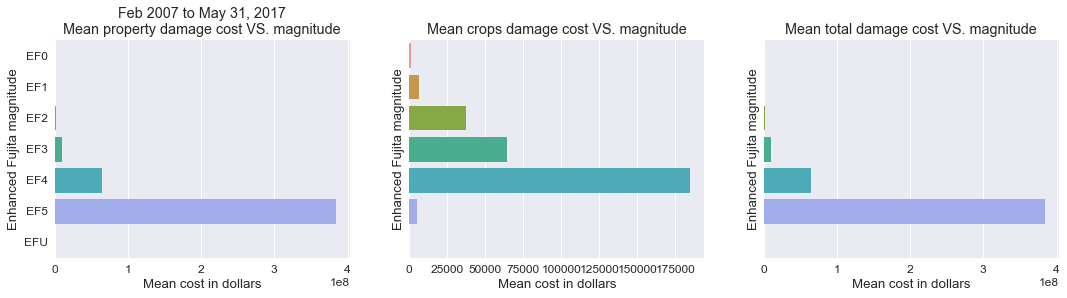

In [85]:
fig, ax = plt.subplots(1,3, figsize=(18,4), sharey=True)

sns.barplot(groupEFscale_2.PropertyDamageCost.mean(), groupEFscale_2.groups.keys(), orient='h',
            ax=ax[0])
sns.barplot(groupEFscale_2.CropsDamageCost.mean(), groupEFscale_2.groups.keys(), orient='h',
            ax=ax[1])
sns.barplot(groupEFscale_2.TotalCost.mean(), groupEFscale_2.groups.keys(), orient='h',
            ax=ax[2])

ax[0].set_title("Feb 2007 to May 31, 2017\nMean property damage cost VS. magnitude")
ax[0].set_ylabel("Enhanced Fujita magnitude")
ax[0].set_xlabel("Mean cost in dollars")

#fig.subplots_adjust(wspace = 1)
ax[1].set_title("Mean crops damage cost VS. magnitude")
ax[1].set_ylabel("Enhanced Fujita magnitude")
ax[1].set_xlabel("Mean cost in dollars")

ax[2].set_title("Mean total damage cost VS. magnitude")
ax[2].set_ylabel("Enhanced Fujita magnitude")
ax[2].set_xlabel("Mean cost in dollars")

plt.show()

Actually, as the crops damage costs are very low compared to the property ones, we visually hardly see any difference between the left and right distributions.
<br>This is one more good reason to gather those two features by summing them up.

In [87]:
# Converting the cost columns into integer numbers:
tornado_2007_2017['TotalCost'] = tornado_2007_2017['PropertyDamageCost'] + \
                                 tornado_2007_2017['CropsDamageCost']
# Removing previous columns related to costs:
tornado_2007_2017.drop(['PropertyDamageCost', 'CropsDamageCost'], axis=1, inplace=True)

For part4 of the capstone project, let's not forget to include the previous two lines of code in the class representing the pre-processing (for later pipeline)

## Studying correlations between numerical features

In [96]:
#Let's recap what are our columns now:
tornado_2007_2017.columns

Index([     u'SOURCE', u'TOR_F_SCALE',  u'TOR_LENGTH',   u'TOR_WIDTH',
          u'Duration', u'AverageDate', u'AverageTime',      u'Deaths',
          u'Injuries',    u'Mean_Lat',    u'Mean_Lon',     u'Azimuth',
             u'State',   u'TotalCost'],
      dtype='object')

In [97]:
# Creating a DF to examine the correlation between the numerical features:
numDF = tornado_2007_2017.drop(['State','SOURCE', 'TOR_F_SCALE'], axis=1)
# Let's transform the EF scale to integer:
numDF['Magnitude'] = tornado_2007_2017['TOR_F_SCALE'].map(convertEFtonb)
numDF.head(2)

,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth,TotalCost,Magnitude
0,0.27,20.0,1,208,15.855,0,0,41.7345,-93.3220,120.34,0,0
1,0.20,20.0,1,208,16.255,0,0,41.6694,-93.0534,117.98,0,0


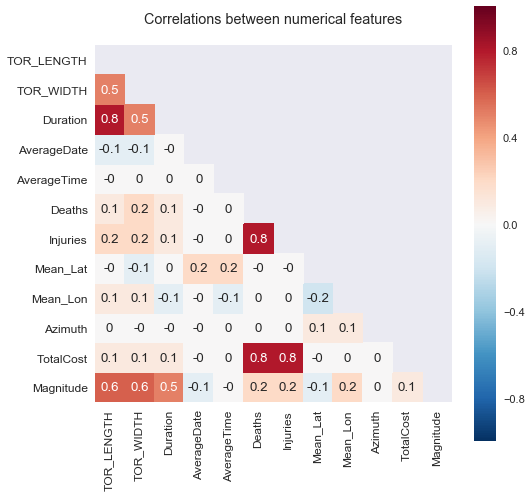

In [98]:
# Heatmap:
mask = np.zeros_like(numDF.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1.2)
plt.figure(figsize=(8,8))
plt.title("Correlations between numerical features\n")
sns.set(font_scale=1.1)
sns.heatmap(numDF.corr().round(1), square=True, annot=True, mask=mask)
plt.show()

Observation from the heatmap:
- Clear strong positive correlation between number of deaths and injuries
- Strong positive correlation between damage costs and number of casualties
- Important positive correlations between Magnitude and Tornado length, Tornado width and duration
- Our new azimuth feature does not seem to have lots of correlations with other features!

In [99]:
# Pairplots with different colors corresponding to magnitude:
sns.pairplot(numDF, hue='Magnitude', size=3)
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Well apparently the number of rows is now too big for my old laptop to derive pairplots!

# Modelling

## Feature Matrix and Target

In [100]:
# Recap:
tornado_2007_2017.columns

Index([     u'SOURCE', u'TOR_F_SCALE',  u'TOR_LENGTH',   u'TOR_WIDTH',
          u'Duration', u'AverageDate', u'AverageTime',      u'Deaths',
          u'Injuries',    u'Mean_Lat',    u'Mean_Lon',     u'Azimuth',
             u'State',   u'TotalCost'],
      dtype='object')

In [101]:
y1 = tornado_2007_2017.reset_index().TOR_F_SCALE
X1 = tornado_2007_2017.reset_index().drop(['TOR_F_SCALE'], axis=1)

## Standardization

In [102]:
# Standardizing numerical features:
numfeat = ['TOR_LENGTH', 'TOR_WIDTH', 'Duration', 'AverageDate', 'AverageTime', 
           'Deaths', 'Injuries', 'Mean_Lat', 'Mean_Lon', 'Azimuth', 'TotalCost']
scaler = StandardScaler()
X1numfeat = pd.DataFrame(scaler.fit_transform(X1[numfeat]), columns=numfeat)
X1numfeat.head(2)

,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth,TotalCost
0,-0.659078,-0.553944,-0.663874,0.718893,0.064674,-0.048936,-0.060172,0.992459,-0.148916,1.408516,-0.042302
1,-0.675226,-0.553944,-0.663874,0.718893,0.142254,-0.048936,-0.060172,0.978564,-0.115505,1.354118,-0.042302


## Dummification

In [103]:
# Checking which State we will drop after dummification (the most common one should be dropped):
tornado_2007_2017.State.value_counts().head(2)

TX    1451
KS    1162
Name: State, dtype: int64

In [104]:
# Checking which Source we will drop after dummification (the most common one should be dropped):
tornado_2007_2017.SOURCE.value_counts().head(2)

NWS_Storm_Survey    9116
Trained_Spotter     1062
Name: SOURCE, dtype: int64

In [105]:
X1dums = pd.get_dummies(X1[['State','SOURCE']], prefix=['State','Source'],
                        columns=['State','SOURCE'])
X1dums.drop(['State_TX','Source_NWS_Storm_Survey'], axis=1, inplace=True)
X1dums.head(2)

,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,...,Source_Official_NWS_Observations,Source_Other_Federal_Agency,Source_Park/Forest_Service,Source_Public,Source_Social_Media,Source_State_Official,Source_Storm_Chaser,Source_Trained_Spotter,Source_Unknown,Source_Utility_Company
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
# Putting back together the standardized and dummifies features:
X1 = pd.concat([X1numfeat,X1dums], axis=1)
print X1.shape, X1numfeat.shape, X1dums.shape
X1.head(2)

(14537, 87) (14537, 11) (14537, 76)


,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth,...,Source_Official_NWS_Observations,Source_Other_Federal_Agency,Source_Park/Forest_Service,Source_Public,Source_Social_Media,Source_State_Official,Source_Storm_Chaser,Source_Trained_Spotter,Source_Unknown,Source_Utility_Company
0,-0.659078,-0.553944,-0.663874,0.718893,0.064674,-0.048936,-0.060172,0.992459,-0.148916,1.408516,...,0,0,0,1,0,0,0,0,0,0
1,-0.675226,-0.553944,-0.663874,0.718893,0.142254,-0.048936,-0.060172,0.978564,-0.115505,1.354118,...,0,0,0,0,0,0,0,0,0,0


## Train/test split

Now that we have more tornadoes, we can stratify in order to have the same proportions of magnitudes between the train and test sets.

In [107]:
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X1, y1, test_size=0.3, 
                                                    stratify=y1, random_state=31)

## Baseline

In [108]:
ytest1.value_counts()

EF0    2298
EF1    1447
EF2     432
EF3     131
EF4      31
EFU      19
EF5       4
Name: TOR_F_SCALE, dtype: int64

The baseline accuracy is the probability to get an EF0 tornado

In [109]:
ytest_valcounts = ytest1.value_counts()
accuracy_baseline = ytest_valcounts.get_values()[0]/float(ytest_valcounts.get_values().sum())
print "Accuracy | Test\t\t | Baseline\t\t | EF0 tornados:\t", round(accuracy_baseline, 3)

Accuracy | Test		 | Baseline		 | EF0 tornados:	0.527


Compared to part 2, because we include many more strong tornadoes, the baseline accuracy is about 10% lower.

Now let's try logistic regression and random forest. The results will be commented after the different models have been trained and scored.

## Logistic Regression

### Default hyperparameters

In [110]:
lr1 = LogisticRegression()
accuracy_cv5_lr1 = np.mean(cross_val_score(lr1, Xtrain1, ytrain1, cv=5))
print "Accuracy | Train CV5\t | Logistic Regresssion\t | Default params:\t", round(accuracy_cv5_lr1, 3)

Accuracy | Train CV5	 | Logistic Regresssion	 | Default params:	0.673


In [111]:
lr1.fit(Xtrain1, ytrain1)
yhat1_lr1 = lr1.predict(Xtest1)
accuracy_lr1 = accuracy_score(ytest1, yhat1_lr1)
print "Accuracy | Test\t\t | Logistic Regresssion\t | Default params:\t", round(accuracy_lr1, 3)

Accuracy | Test		 | Logistic Regresssion	 | Default params:	0.679


### Optimization

A first GridSearch pass converged to a C of 100. I am know trying to refine it:

In [135]:
params_logreg_v1 = {'penalty': ['l1','l2'], 'C':np.logspace(2,6,5)}
lr2 = GridSearchCV(lr1, param_grid=params_logreg_v1, cv=5)
lr2.fit(Xtrain1, ytrain1)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [136]:
lr2.best_params_

{'C': 1000000.0, 'penalty': 'l2'}

Gridsearch tends to no regularization (high C)

In [137]:
print "Accuracy | Train CV5\t | Logistic Regresssion\t | Optimal params:\t", round(lr2.best_score_, 3)

Accuracy | Train CV5	 | Logistic Regresssion	 | Optimal params:	0.684


In [138]:
lr3 = lr2.best_estimator_.fit(Xtrain1, ytrain1)
yhat1_lr3 = lr3.predict(Xtest1)
accuracy_lr3 = accuracy_score(ytest1, yhat1_lr3)
print "Accuracy | Test\t\t | Logistic Regresssion\t | Optimal params:\t", round(accuracy_lr3, 3)

Accuracy | Test		 | Logistic Regresssion	 | Optimal params:	0.688


## Random Forest

### Default hyperparameters

In [113]:
rf1 = RandomForestClassifier(random_state=31)
accuracy_cv5_rf1 = np.mean(cross_val_score(rf1, Xtrain1, ytrain1, cv=5))
print "Accuracy | Train CV5\t | Random Forest\t | Default params:\t", round(accuracy_cv5_rf1, 3)

Accuracy | Train CV5	 | Random Forest	 | Default params:	0.7


In [114]:
rf1.fit(Xtrain1, ytrain1)
yhat1_rf1 = rf1.predict(Xtest1)
accuracy_rf1 = accuracy_score(ytest1, yhat1_rf1)
print "Accuracy | Test\t\t | Random Forest\t | Default params:\t", round(accuracy_rf1, 3)

Accuracy | Test		 | Random Forest	 | Default params:	0.706


In [115]:
# Using the same best parameters as in part 2:
rf2 = RandomForestClassifier(criterion='gini', max_depth=7, max_features=0.7, min_samples_leaf=1,
                             min_samples_split=5, n_estimators=24, random_state=31)
rf2.fit(Xtrain1, ytrain1)
yhat1_rf2 = rf2.predict(Xtest1)
accuracy_rf2 = accuracy_score(ytest1, yhat1_rf2)
print "Accuracy | Test\t\t | Random Forest\t | Part2 params:\t\t", round(accuracy_rf2, 3)

Accuracy | Test		 | Random Forest	 | Part2 params:		0.724


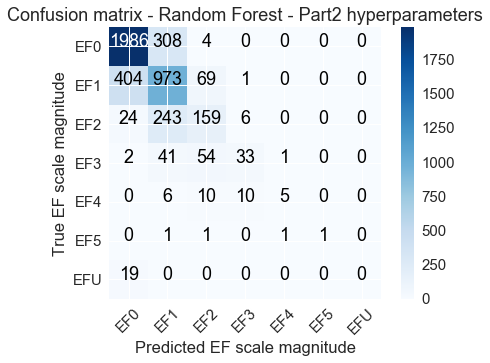

In [145]:
# Computing the confusion matrix
confmatrix_rf2 = confusion_matrix(ytest1, rf2.predict(Xtest))

# Plotting it using the function:
sns.set(font_scale=1.5)
plt.figure(figsize=(7,5))
plot_confusion_matrix(confmatrix_rf2, rf2.classes_,
                      'Confusion matrix - Random Forest - Part2 hyperparameters',
                      xlab='Predicted EF scale magnitude', ylab='True EF scale magnitude')
plt.show()

Observations from confusion matrix of our best model so far:
- Most EF0 tornados are correctly predicted.
- EF1 to EF5 tornadoes are more likely to be predicted as weaker magnitude
- All the unidentified EFU tornadoes are predicted as EF0, which makes the most sense as they are tornadoes which produce little damage, or which collected data were not sufficient enough to infer the magnitude. In that sense, the model works well.

### Gridsearching random forest

In [116]:
params_randfor_v1 = {'criterion': ['gini','entropy'],
                     'max_depth': [10,15],
                     'max_features': [0.4,0.6,0.8],
                     'n_estimators': [20, 40, 60, 80],
                     'min_samples_split': [6, 10, 14],
                     'min_samples_leaf': [1,2]
                    }

rf3 = GridSearchCV(rf1, param_grid=params_randfor_v1, cv=5, verbose=1, n_jobs=2)
rf3.fit(Xtrain1, ytrain1)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  5.5min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 13.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 27.0min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed: 46.4min
[Parallel(n_jobs=2)]: Done 1440 out of 1440 | elapsed: 68.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=31,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'min_samples_leaf': [1, 2], 'n_estimators': [20, 40, 60, 80], 'min_samples_split': [6, 10, 14], 'criterion': ['gini', 'entropy'], 'max_features': [0.4, 0.6, 0.8], 'max_depth': [10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [117]:
rf3.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 0.4,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 60}

In [119]:
print "Accuracy | Train CV5\t | Random Forest\t | Optimal params:\t", round(rf3.best_score_, 3)

Accuracy | Train CV5	 | Random Forest	 | Optimal params:	0.72


In [120]:
rf4 = rf3.best_estimator_
rf4.fit(Xtrain1, ytrain1)

yhat1_rf4 = rf4.predict(Xtest1)
accuracy_rf4 = accuracy_score(ytest1, yhat1_rf4)
print "Accuracy | Test\t\t | Random Forest\t | Optimized params:\t", round(accuracy_rf4, 3)

Accuracy | Test		 | Random Forest	 | Optimized params:	0.732


Further gridsearch:

In [149]:
params_randfor_v2 = {'criterion': ['entropy'],
                     'max_depth': [16,18,20],
                     'max_features': [0.3,0.4,0.5],
                     'n_estimators': [68,70,72],
                     'min_samples_split': [8,9,10],
                     'min_samples_leaf': [1]
                    }

rf5 = GridSearchCV(rf1, param_grid=params_randfor_v2, cv=5, verbose=1, n_jobs=2)
rf5.fit(Xtrain1, ytrain1)

print "\nBest params:", rf5.best_params_

print "\nAccuracy | Train CV5\t | Random Forest\t | Optimal params:\t", round(rf5.best_score_, 3)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 12.9min
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed: 28.2min finished



Best params: {'min_samples_leaf': 1, 'n_estimators': 72, 'min_samples_split': 9, 'criterion': 'entropy', 'max_features': 0.4, 'max_depth': 18}

Accuracy | Train CV5	 | Random Forest	 | Optimal params:	0.724


In [121]:
# First time use after gridsearch: rf6 = rf5.best_estimator_
# Not to have to rerun the gridsearch again:
rf6 = RandomForestClassifier(criterion='entropy', max_depth=18, max_features=0.4, 
                             min_samples_leaf=1, min_samples_split=9, 
                             n_estimators=72, random_state=31)
rf6.fit(Xtrain1, ytrain1)

yhat1_rf6 = rf6.predict(Xtest1)
accuracy_rf6 = accuracy_score(ytest1, yhat1_rf6)
print "Accuracy | Test\t\t | Random Forest\t | Optimized params:\t", round(accuracy_rf6, 3)

Accuracy | Test		 | Random Forest	 | Optimized params:	0.732


## Analysing our best model so far

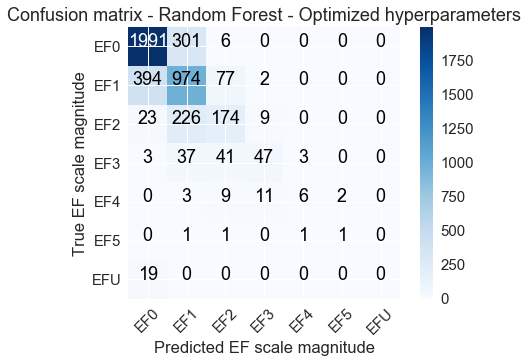

In [122]:
# Computing the confusion matrix
confmatrix_rf6 = confusion_matrix(ytest1, rf6.predict(Xtest1))

# Plotting it using the function:
sns.set(font_scale=1.5)
plt.figure(figsize=(7,5))
plot_confusion_matrix(confmatrix_rf6, rf6.classes_,
                      'Confusion matrix - Random Forest - Optimized hyperparameters',
                      xlab='Predicted EF scale magnitude', ylab='True EF scale magnitude')
plt.show()

Compared to previous RF confusion matrix, we have improved the prediction of EF3 tornadoes for example. Now most are predicted correctly. Before, they were in majority predicted as EF2.
<br>Nevertheless, although we are on the right track, the model still needs improvement

Now let's have a look which are the most influencial features for prediction of the tornado's EF scale:

In [130]:
# Creating a DF out of the coefficients, and sorting them in order of importance of 
# their absolute value:
importanceDF_rf6 = pd.DataFrame({'Importances': rf6.feature_importances_},
                          index = Xtrain1.columns)
importanceDF_rf6.T

,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth,...,Source_Official_NWS_Observations,Source_Other_Federal_Agency,Source_Park/Forest_Service,Source_Public,Source_Social_Media,Source_State_Official,Source_Storm_Chaser,Source_Trained_Spotter,Source_Unknown,Source_Utility_Company
Importances,0.115962,0.241472,0.043825,0.053095,0.060274,0.013532,0.035016,0.064657,0.079055,0.055944,...,0.000109,0.000844,0.000131,0.001029,0.000264,0.000011,0.009168,0.004238,0.000003,0.000088


In [162]:
# Most important features:
mostimp_rf6 = importanceDF_rf6.sort_values(by="Importances", ascending=False)
mostimp_rf6.head(3)

,Importances
TOR_WIDTH,0.241472
TotalCost,0.160599
TOR_LENGTH,0.115962


Let's visually analyse which features influence the most our modelling:

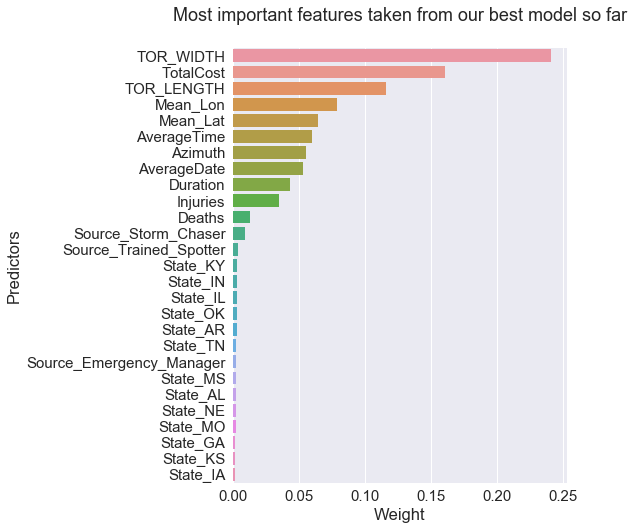

In [161]:
# Horizontal bar plot
plt.figure(figsize=(6,8))
sns.barplot(list(mostimp_rf6[mostimp_rf6['Importances']>0.002].values), 
            [str(i) for i in list(mostimp_rf6[mostimp_rf6['Importances']>0.002].index)], 
            orient='h')
plt.xlabel("Weight")
plt.ylabel("Predictors")
plt.title("Most important features taken from our best model so far\n")
plt.show()

Comments:
- By far, the width is the feature which helps the most predicting the strength of a tornado. The wider the tornado, the very likely it will be destructive.
- The total cost of damages is the second most important feature. This is logic, as the EF scale is based on the damage caused.
- As we saw before, length and width are highly correlated. It makes sense that the longer the tornado is, the most damage it is likely to provoke.
- As we saw also from our EDA and from litterature, tornadoes are most frequent in the "tornado alley" of the Great Plains. It is therefore very logic that the next most influencial features are location related: longitude and latitude (for this latest, the Center and Southern states are more touched by tornadoes than the Northern ones).
- I was expecting injuries and deaths to be more influential factors. However it probably mostly depends on the tornado's path: a very strong tornado can be located in the fields and not make any casualties.
- Source and states are not important factors. However we can note that the most influencial sources are not professionals: storm chaser and trained spotters. These are the persons who will be more likely to spot the weakest (and most frequent) tornadoes. Radars have a harder time detecting those.

## Stolen idea from Andrew ;) -> Neural Network!

### Dropping categorical features for testing Neural Network

As neural network is very heavy, I want to test it with a limited number of features. The easiest way to achieve this is dropping the categorical ones.
<br>In order to have a fair comparison, I am redoing first the Logistic Regression and RF using only the non-categorical features.

In [164]:
X2 = X1numfeat.copy()
print X2.shape

(14537, 11)


In [165]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y1, test_size=0.3, 
                                                    stratify=y1, random_state=31)

### Logistic Regression

In [166]:
# Same parameters as the best one we obtained:
lr4 = LogisticRegression(penalty='l2', C=1000000)
accuracy_cv5_lr4 = np.mean(cross_val_score(lr4, Xtrain2, ytrain2, cv=5))
print "Accuracy | Train CV5\t | Logistic Regresssion\t | Default params\t | No dummies:\t", round(accuracy_cv5_lr4, 3)

Accuracy | Train CV5	 | Logistic Regresssion	 | Default params	 | No dummies:	0.655


In [167]:
lr4.fit(Xtrain2, ytrain2)
yhat2_lr4 = lr4.predict(Xtest2)
accuracy_lr4 = accuracy_score(ytest2, yhat2_lr4)
print "Accuracy | Test\t\t | Logistic Regresssion\t | Default params\t | No dummies:\t", round(accuracy_lr4, 3)

Accuracy | Test		 | Logistic Regresssion	 | Default params	 | No dummies:	0.653


### Random Forest

In [168]:
# Same parameters as the best one we obtained:
rf7 = RandomForestClassifier(criterion='entropy', max_depth=18, max_features=0.4, 
                             min_samples_leaf=1, min_samples_split=9,
                             n_estimators=72, random_state=31)
accuracy_cv5_rf7 = np.mean(cross_val_score(rf7, Xtrain2, ytrain2, cv=5))
print "Accuracy | Train CV5\t | Random Forest\t | Default params\t | No dummies:\t", round(accuracy_cv5_rf7, 3)

Accuracy | Train CV5	 | Random Forest	 | Default params	 | No dummies:	0.714


In [170]:
rf7.fit(Xtrain2, ytrain2)
yhat2_rf7 = rf7.predict(Xtest2)
accuracy_rf7 = accuracy_score(ytest2, yhat2_rf7)
print "Accuracy | Test\t\t | Random Forest\t | Default params\t | No dummies:\t", round(accuracy_rf7, 3)

Accuracy | Test		 | Random Forest	 | Default params	 | No dummies:	0.732


### Recurrent Neural Network

I found this very well documented page https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
which allowed me to "easily" implement a neural network with keras

In [66]:
#X2.reset_index(drop=True, inplace=True)
np.random.seed(7)
# create model
model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [67]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
# Fit the model
# To make it work, I had to transform the target into a numerical feature
model.fit(np.array(Xtrain2),
          np.array(ytrain2.map(convertEFtonb)),
          epochs=150, batch_size=10)

Epoch 1/150
10903/10903 [==============================] - 6s - loss: -0.8321 - acc: 0.6164     
Epoch 2/150
10903/10903 [==============================] - 5s - loss: -1.5841 - acc: 0.6528     
Epoch 3/150
10903/10903 [==============================] - 5s - loss: -1.6652 - acc: 0.6603     
Epoch 4/150
10903/10903 [==============================] - 5s - loss: -1.7027 - acc: 0.6625     
Epoch 5/150
10903/10903 [==============================] - 5s - loss: -1.7313 - acc: 0.6635     
Epoch 6/150
10903/10903 [==============================] - 5s - loss: -1.7545 - acc: 0.6641     
Epoch 7/150
10903/10903 [==============================] - 5s - loss: -1.7737 - acc: 0.6640     
Epoch 8/150
10903/10903 [==============================] - 5s - loss: -1.7896 - acc: 0.6670     
Epoch 9/150
10903/10903 [==============================] - 5s - loss: -1.8041 - acc: 0.6650     
Epoch 10/150
10903/10903 [==============================] - 4s - loss: -1.8150 - acc: 0.6665     
Epoch 11/150
10903/10903 [===

I was so happy to see it run and see the accuracy increasing after each epoch!
Probably would need more iterations

In [92]:
# Predictions on the test set:
yhat2_rnn1 = model.predict(np.array(Xtest2))
len(yhat2_rnn1)

3635

In [114]:
# Transforming the target to array:
ytest2array = np.array(ytest2.map(convertEFtonb))
ytest2array.shape

(3635,)

In [117]:
# Need to round up the predictions to closest integer, in order to be comparable to 
# the actual integer target:
yhat2_rnn1trans = np.empty_like(ytest2array)
for i in range(len(yhat2_rnn1)):
    yhat_rnn1trans[i] = int(round(float(yhat_rnn1[i])))

yhat2_rnn1trans.shape

(3635,)

In [234]:
accuracy_rnn1 = accuracy_score(ytest2array, yhat2_rnn1trans)
print "Accuracy | Test\t\t | Logistic Regresssion\t\t | Default params\t | No dummies:\t", round(accuracy_lr2, 3)
print "Accuracy | Test\t\t | Random Forest\t\t | Default params\t | No dummies:\t", round(accuracy_rf7, 3)
print "Accuracy | Test\t\t | Recursive Neural Network\t | Test params:\t\t\t", round(accuracy_rnn1, 3)

Accuracy | Test		 | Logistic Regresssion	 | Default params	 | No dummies:	0.639
Accuracy | Test		 | Random Forest	 | Default params	 | No dummies:	0.712
Accuracy | Test		 | Recursive Neural Network	 | Test params:	0.678


Just with default parameters, Random Forest is the best.
<br>RNN needs much further testing to get effective results.

## Recap of the various model scores

#### With all the features:

| Type | Train or Test | Model | Parameters | Score |
| :---: | :---: | :---: | :---: | :--- |
| Accuracy | Both | Baseline | EF0 tornados | 0.527 |
| Accuracy | Train CV5 | Logistic Regresssion | Default | 0.673 |
| Accuracy | Train CV5 | Logistic Regresssion | Optimized | 0.684 |
| Accuracy | Train CV5	| Random Forest | Default | 0.700 |
| Accuracy | Train CV5 | Random Forest | Optimized | 0.724 |

| Type | Train or Test | Model | Parameters | Score |
| :---: | :---: | :---: | :---: | :--- |
| Accuracy | Both | Baseline | EF0 tornados | 0.527 |
| Accuracy | Test | Logistic Regresssion | Default | 0.679 |
| Accuracy | Test | Logistic Regresssion | Optimized | 0.688 |
| Accuracy | Test	| Random Forest | Default | 0.706 |
| Accuracy | Test	| Random Forest | From part2 | 0.724 |
| Accuracy | Test | Random Forest | Optimized | 0.732 |

#### Without the dummy features, for RNN validation:

| Type | Train or Test | Model | Parameters | Score |
| :---: | :---: | :---: | :---: | :--- |
| Accuracy | Both | Baseline | EF0 tornados | 0.527 |
| Accuracy | Test | Logistic Regresssion | Optimized | 0.688 |
| Accuracy | Test | Random Forest | Optimized | 0.732 |
| Accuracy | Test | Recurrent Neural Network | Default | 0.678 |

Comments:
- I would like to work more on the RNN, and try and understand the concept better in order to find better parameters. Further testing is needed.
- We get the same accuracy scores without the dummy features. Interesting! We can therefore reduce the number of features and run models faster with the same outcome.
- Random forest works really well on these data.
- We obtained a gain of about 39% over the baseline.

Next tests for improving the models:
- I could still fine tune the gridsearches
- I could also try other types of models
- Most importantly: Upsampling the stronger and rarer tornadoes

# PCA

Let's try and see if strongly correlated features could be reduced by Principal Component Analysis, and still obtain a good model accuracy

In [172]:
pca = PCA()
pca.fit(Xtrain2)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [174]:
# Obtaining the eigen vectors
cols = ['PC{}'.format(i) for i in range(1,12)]
princomps = pca.components_
princompsDF = pd.DataFrame(princomps, columns=cols, index=Xtrain2.columns)
print princompsDF.shape
princompsDF

(11, 11)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
TOR_LENGTH,0.337276,0.298948,0.314776,-0.052509,0.005041,0.559171,0.449807,-0.038555,0.030683,0.000727,0.421404
TOR_WIDTH,-0.521941,-0.380307,-0.515378,0.089754,-0.002256,0.372377,0.280578,0.050273,-0.029918,0.018218,0.296860
Duration,-0.028494,0.046596,-0.157683,-0.287694,-0.472937,-0.005158,-0.003206,-0.630648,0.505618,-0.110759,-0.006713
AverageDate,-0.002207,-0.026292,0.088779,0.441810,-0.252029,0.006087,0.010235,-0.085469,-0.239790,-0.817156,0.004219
AverageTime,-0.093976,0.015268,-0.037930,-0.748536,0.258722,0.008823,-0.001957,-0.160390,-0.475174,-0.332572,0.007228
Deaths,0.027891,-0.111145,0.099855,-0.155028,-0.782434,0.007164,0.003095,0.197667,-0.467155,0.288407,0.010769
Injuries,-0.052488,0.058296,0.032770,0.349291,0.153367,-0.004927,-0.001557,-0.710905,-0.465169,0.354146,-0.005719
Mean_Lat,-0.266019,0.860004,-0.380420,0.060076,-0.099494,-0.013879,-0.034264,0.144008,-0.091580,0.006012,-0.029523
Mean_Lon,-0.724818,0.085692,0.665713,-0.034693,-0.014694,-0.023012,-0.028384,-0.002515,0.127149,0.020083,0.069220
Azimuth,-0.052543,0.002896,0.018531,-0.008055,-0.001837,-0.274371,0.824977,0.006030,0.000404,0.003280,-0.490822


By analysing the eigen values, we can see that PC1 represents mostly the longitude and the width, PC2 the Latitude

In [175]:
# Let's transform our feature matrix into the new coordinate system:
Xtrain2_PC = pd.DataFrame(pca.transform(Xtrain2), columns=cols)
Xtest2_PC = pd.DataFrame(pca.transform(Xtest2), columns=cols)
print Xtrain2_PC.shape, Xtest2_PC.shape
Xtrain2_PC.head(2)

(10175, 11) (4362, 11)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-0.590168,0.772521,0.385351,-0.471694,-0.989970,-0.560806,-0.501940,-0.059585,0.251016,0.008228,-0.021016
1,1.649615,-2.470692,-1.038995,-0.129349,-1.868297,-0.297628,-0.807415,-0.517763,-0.370944,-0.207332,0.167550


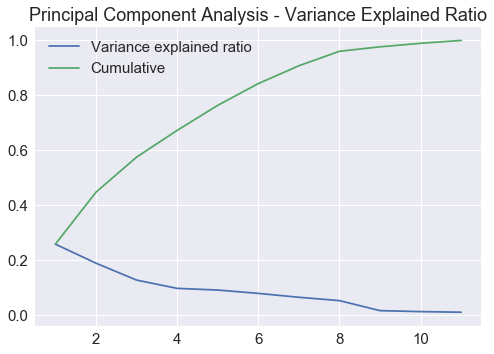

In [177]:
# Variance Explained Ration
cumulratio = []
sum=0
for i in range(0,11):
    sum += pca.explained_variance_ratio_[i]
    cumulratio.append(sum)
    
plt.plot(range(1,12), pca.explained_variance_ratio_)
plt.plot(range(1,12), cumulratio)
plt.title("Principal Component Analysis - Variance Explained Ratio")
plt.legend(["Variance explained ratio","Cumulative"])
plt.show()

This graphs tell us that taking the 7 first principal components should explain about 90% of our data.

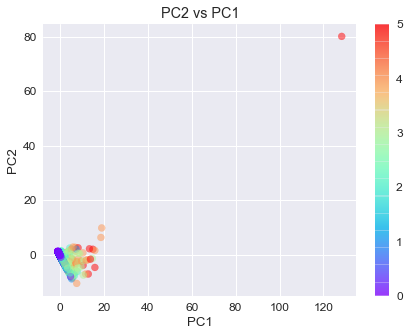

In [178]:
# Let's plot the first and second principal components
plt.figure(figsize=(7,5))
sns.set(font_scale=1.2)
plt.scatter(Xtrain2_PC.PC1, Xtrain2_PC.PC2, alpha=0.5,\
            c=ytrain2.map(convertEFtonb), cmap='rainbow')
plt.title('PC2 vs PC1')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Investigating the outlier:

In [179]:
Xtrain2_PC[Xtrain2_PC['PC1']>20]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
3057,128.334004,80.06766,-1.758452,1.162416,1.269434,1.703984,-0.426789,-3.418334,1.757103,-3.672574,-0.45631


In [180]:
Xtrain2.iloc[3057, :]

TOR_LENGTH       1.308722
TOR_WIDTH        4.801062
Duration         2.051181
AverageDate     -0.133078
AverageTime      0.253775
Deaths         102.947230
Injuries        77.158277
Mean_Lat        -0.006307
Mean_Lon        -0.294238
Azimuth          0.722310
TotalCost       79.594937
Name: 6751, dtype: float64

Seems like the number of deaths is really much higher than usual (102 times the standard deviation!). Must correspond to a strong tornado

In [181]:
ytrain2.iloc[3057]

u'EF5'

Indeed!

## Rebuilding our best model with the 7 first principal components

In [182]:
rf8 = RandomForestClassifier(criterion='entropy', max_depth=18, max_features=0.4, 
                             min_samples_leaf=1, min_samples_split=9, 
                             n_estimators=72, random_state=31)
accuracy_cv5_rf8 = np.mean(cross_val_score(rf8, Xtrain2_PC[['PC{}'.format(i) 
                                                            for i in range(1,8)]],
                                           ytrain2, cv=5))
print "Accuracy | Train CV5\t | Random Forest\t | Default params\t | No dummies + PC:\t", round(accuracy_cv5_rf8, 3)

Accuracy | Train CV5	 | Random Forest	 | Default params	 | No dummies + PC:	0.655


In [183]:
rf8.fit(Xtrain2_PC[['PC{}'.format(i) for i in range(1,8)]], ytrain2)
yhat2_rf8 = rf8.predict(Xtest2_PC[['PC{}'.format(i) for i in range(1,8)]])
accuracy_rf8 = accuracy_score(ytest2, yhat2_rf8)
print "Accuracy | Test\t\t | Random Forest\t | Default params\t | No dummies + PC:\t", round(accuracy_rf8, 3)

Accuracy | Test		 | Random Forest	 | Default params	 | No dummies + PC:	0.663


Without the dummy features:

| Type | Train or Test | Model | Parameters | Components | Score |
| :---: | :---: | :---: | :---: | :---: | :--- |
| Accuracy | Both | Baseline | EF0 tornados | | 0.527 |
| Accuracy | Test | Logistic Regresssion | Optimized | Original 11 | 0.688 |
| Accuracy | Test | Random Forest | Optimized | Original 11 | 0.732 |
| Accuracy | Test | Random Forest | As prior | PC 7 | 0.663 |

Well, seems like reducing the number of components to 7 based on PCA does not help in this case. It reduces too much the accuracy to actually want to reduce the components. Obviously we should do a gridsearch again to try and improve.
<br>Let's analyse and loop over all the component reduction possibilities:

In [184]:
for nbPC in range(2,13):
    accuracyperPC = np.mean(cross_val_score(rf8, Xtrain2_PC[['PC{}'.format(i) 
                                                             for i in range(1,nbPC)]],
                                            ytrain2, cv=5))
    print "For {} components, the CV accuracy score of RF is: ".format(nbPC-1), accuracyperPC

For 1 components, the CV accuracy score of RF is:  0.587613838519
For 2 components, the CV accuracy score of RF is:  0.647081950982
For 3 components, the CV accuracy score of RF is:  0.644037193277
For 4 components, the CV accuracy score of RF is:  0.639519885622
For 5 components, the CV accuracy score of RF is:  0.649836982484
For 6 components, the CV accuracy score of RF is:  0.654353910142
For 7 components, the CV accuracy score of RF is:  0.654551194833
For 8 components, the CV accuracy score of RF is:  0.677939752285
For 9 components, the CV accuracy score of RF is:  0.675581173886
For 10 components, the CV accuracy score of RF is:  0.680593027875
For 11 components, the CV accuracy score of RF is:  0.684917742738


- The best score is obtained with the 11 principal components. And still, it is worse than with the original 11 components. 
- In our study, PCA could not be used to efficiently reduce the number of components and still obtain a good score.
- If the number of features is really an issue for performance, or if we want to try heavy models, we could still reduce to 6 components even though we would lose 9% accuracy.
- Note: try gridsearch on the PCA!

# NLP

We have the chance to have a detailed event narrative for each tornado.
<br>We can then process it by taking out the most important words to describe the magnitude of a tornado
<br>This is done through Natural Languange Processing
<br>Let's first retrieve again the event narrative from the original features

In [74]:
raw_2007_2017.columns

Index([u'BEGIN_YEARMONTH', u'BEGIN_DAY', u'BEGIN_TIME', u'END_YEARMONTH',
       u'END_DAY', u'END_TIME', u'EPISODE_ID', u'EVENT_ID', u'STATE',
       u'STATE_FIPS', u'YEAR', u'MONTH_NAME', u'EVENT_TYPE', u'CZ_TYPE',
       u'CZ_FIPS', u'CZ_NAME', u'WFO', u'BEGIN_DATE_TIME', u'CZ_TIMEZONE',
       u'END_DATE_TIME', u'INJURIES_DIRECT', u'INJURIES_INDIRECT',
       u'DEATHS_DIRECT', u'DEATHS_INDIRECT', u'DAMAGE_PROPERTY',
       u'DAMAGE_CROPS', u'SOURCE', u'MAGNITUDE', u'MAGNITUDE_TYPE',
       u'FLOOD_CAUSE', u'CATEGORY', u'TOR_F_SCALE', u'TOR_LENGTH',
       u'TOR_WIDTH', u'TOR_OTHER_WFO', u'TOR_OTHER_CZ_STATE',
       u'TOR_OTHER_CZ_FIPS', u'TOR_OTHER_CZ_NAME', u'BEGIN_RANGE',
       u'BEGIN_AZIMUTH', u'BEGIN_LOCATION', u'END_RANGE', u'END_AZIMUTH',
       u'END_LOCATION', u'BEGIN_LAT', u'BEGIN_LON', u'END_LAT', u'END_LON',
       u'EPISODE_NARRATIVE', u'EVENT_NARRATIVE', u'DATA_SOURCE'],
      dtype='object')

In [75]:
#Examples of texts:
for i in range(7):
    print raw_2007_2017.TOR_F_SCALE[i+1001], ' - ', raw_2007_2017.EVENT_NARRATIVE[i+1001],"\n"

EF0  -  A couple intermittent and brief touchdowns occurred along the edge of a field and into a line of trees. The tornado travelled less than a half mile. A few large tree limbs were broken down. Peak winds were estimated at 80 mph. 

EF0  -  An ef0 tornado started about 3 miles south of Uehling around 527 pm. The tornado tracked to the north northeast damaging some farm buildings, trees and hay stacks.  The tornado ended about 1 mile east of uehling around 532 pm. 

EF0  -  Trained storm spotter reported a tornado about 4 miles west of the intersection of Krome Avenue and Kendall Drive in unpopulated Miami-Dade County. Law enforcement confirmed the tornado, which did no damage. 

EF2  -  Numerous trees were snapped and uprooted as the tornado touched down. Three mobile homes were destroyed, including one with a bent frame. Debris from mobile homes was thrown several hundred yards. A resident of one of the mobile homes received a minor head injury when a tree fell into his residence.

In [186]:
# Feature matrix (removing the bad row already removed before for tornado_2007_2017)
X3 = raw_2007_2017[raw_2007_2017.TOR_LENGTH<50]['EVENT_NARRATIVE']

In [187]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y1, stratify=y1, test_size=0.3, 
                                                        random_state=52)
print X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape

(10175,) (4362,) (10175,) (4362,)


In [188]:
# We do not want any stop words
# ngrams are important as for instance "no damage" cannot be discarded and viewed as "damage"
countvec1 = CountVectorizer(stop_words='english', ngram_range=(1,2))
X_train3_transf = countvec1.fit_transform(X_train3)
X_test3_transf = countvec1.transform(X_test3)

In [189]:
# Displaying the most frequent words:
pd.DataFrame(X_train3_transf.todense(), 
             columns=countvec1.get_feature_names()).sum(axis=0)\
                     .sort_values(ascending=False).head(30)

tornado            23090
damage             14545
county              8900
trees               8229
road                6975
near                4758
path                4455
miles               4260
touched             4039
northeast           3996
snapped             3737
roof                3711
mph                 3703
homes               3495
east                3461
damaged             3376
destroyed           3276
just                3227
north               3110
home                3018
estimated           2989
tornado touched     2981
highway             2926
tree                2897
moved               2780
winds               2704
uprooted            2681
large               2679
south               2445
maximum             2296
dtype: int64

From that list of words, and the few narratives examples I listed, I get other ideas to improve the process. Stop words should be increased by introducing:
- "tornado" which does not bring anything to our study (we already know all events are tornadoes!)
- "mph"
- all kind of numbers
- any reference to our target: EF0, EF1... should not be used

In [80]:
# Function that accepts a vectorizer and calculates the accuracy 
def tokenize_test(vect, Xtrain=X_train3, Xtest=X_test3, ytrain=y_train3, ytest=y_test3):
    '''From a CountVectorizer model input and a train and test feature matrix and target
    Fits a Naive Bayes multinomial model on train data and prints the test accuracy score'''
    Xtrain_vect = vect.fit_transform(Xtrain)
    print '\nNumber of features: ', Xtrain_vect.shape[1]
    Xtest_vect = vect.transform(Xtest)
    nb = MultinomialNB()
    nb.fit(Xtrain_vect, ytrain)
    yhat = nb.predict(Xtest_vect)
    print "Accuracy | Test\t\t | MultNB\t | Default params\t | Default tokens :\t", round(accuracy_score(ytest, yhat), 3)

In [81]:
tokenize_test(countvec1)


Number of features:  152211
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.738


The best accuracy we had before was with RF: 0.732. Without tweeking the parameters, we already get a better score.

## Max features optimization

In [82]:
#Let's loop over it to find the bext max_feature:
for i in [5000, 10000, 20000, 50000, 100000, 152211]:
    countvecrange = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=i)
    tokenize_test(countvecrange)


Number of features:  5000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.777

Number of features:  10000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.777

Number of features:  20000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.787

Number of features:  50000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.774

Number of features:  100000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.749

Number of features:  152211
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.738


In [83]:
#Let's narrow the search down:
for i in [10000, 15000, 20000, 25000, 30000, 35000]:
    countvecrange = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=i)
    tokenize_test(countvecrange)


Number of features:  10000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.777

Number of features:  15000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.786

Number of features:  20000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.787

Number of features:  25000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.786

Number of features:  30000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.783

Number of features:  35000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.78


In [84]:
# Narrowing down the search:
for i in range(15000, 26000, 1000):
    countvecrange = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=i)
    tokenize_test(countvecrange)


Number of features:  15000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.786

Number of features:  16000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.786

Number of features:  17000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.785

Number of features:  18000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.784

Number of features:  19000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.785

Number of features:  20000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.787

Number of features:  21000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.785

Number of features:  22000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.785

Number of features:  23000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.785

Number of features:  24000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.785

Number of

**20000 max features seems the best**

In [85]:
countvec2 = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=20000)
tokenize_test(countvec2)


Number of features:  20000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.787


We improved on RF again: 0.787 compared to 0.732.

## Lemmatization

Let's try to gather words with the same roots, in order to reduce the number of features and hopefully improve the accuracy:

In [86]:
def split_into_lemmas(text):
    #text = unicode(text, 'utf-8').lower()
    text = text.lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]

In [87]:
countvec3 = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=20000,
                            analyzer=split_into_lemmas)
tokenize_test(countvec3)


Number of features:  19107
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.748


We now realize that the total number of words has been drastically reduced by lemmatization: 19107.

In [88]:
# Max features may have to be adapted after words have been lemmatized:
for i in range(2000,11000,1000):
    countvectest = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=i,
                                   analyzer=split_into_lemmas)
    tokenize_test(countvectest)


Number of features:  2000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.759

Number of features:  3000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.76

Number of features:  4000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.757

Number of features:  5000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.759

Number of features:  6000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.762

Number of features:  7000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.762

Number of features:  8000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.762

Number of features:  9000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.761

Number of features:  10000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.76


In [89]:
# Narrowing down the search:
for i in [100, 200, 500, 1000, 1500]:
    countvectest = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=i,
                                   analyzer=split_into_lemmas)
    tokenize_test(countvectest)


Number of features:  100
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.641

Number of features:  200
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.7

Number of features:  500
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.745

Number of features:  1000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.757

Number of features:  1500
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.755


The optimal number of features with lemmatization is 7000. However the accuracy is still less than without it.

Better off without lemmatization

## TF-IDF

Now let's analyse if deriving a word importance matrix based on TF-IDF technology can improve our modelling

In [90]:
tfidfvec1 = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
tokenize_test(tfidfvec1)


Number of features:  152211
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.732


In [91]:
# Max features test:
for i in range(500,5500,500):
    tfidfvectest = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=i)
    tokenize_test(tfidfvectest)


Number of features:  500
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.748

Number of features:  1000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.761

Number of features:  1500
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.764

Number of features:  2000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.76

Number of features:  2500
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.761

Number of features:  3000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.759

Number of features:  3500
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.757

Number of features:  4000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.752

Number of features:  4500
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.752

Number of features:  5000
Accuracy | Test		 | MultNB	 | Default params	 | Default tokens :	0.752


### A few conclusions from our quick NLP analysis:
- Lemmatization does not help
- TF IDF does not help improving the accuracy
- The best score is obtained with CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=20000): <br>0.787
- We can further improve NLP by including more stop words ("tornado", "mph", any reference to tornado target "EF0"..., any numbers because they can indicate wind speed, which we do not want here as we would like our modelling to work only with descriptive words)
- Parameters can probably be better chosen

# Time Series Analysis

Let's work from the PostgreSQL database to derive the count of tornadoes per month

In [92]:
sql_query = """
SELECT *
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702
LIMIT 2
"""
pd.read_sql(sql_query, engine_local)

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,200807,27,1551,200807,27,1552,18375.0,107468,IOWA,19.0,...,1.0,ENE,VALERIA,41.7357,-93.324,41.7333,-93.3199,A very unstable airmass was in place over Iowa...,Funnel visible nearly to the ground with circu...,CSV
1,200807,27,1615,200807,27,1616,18375.0,107469,IOWA,19.0,...,2.0,WSW,NEWTON MUNI ARPT,41.6703,-93.055,41.6686,-93.0518,A very unstable airmass was in place over Iowa...,Brief touchdown just south of Newton.,CSV


In [93]:
# Checking that from 2007 we only have EF scale data:
sql_query = """
SELECT "BEGIN_YEARMONTH", COUNT("BEGIN_YEARMONTH") as "COUNTTORNADOES"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702
GROUP BY "BEGIN_YEARMONTH"
ORDER BY "BEGIN_YEARMONTH" ASC
LIMIT 3
"""
pd.read_sql(sql_query, engine_local)

,BEGIN_YEARMONTH,COUNTTORNADOES
0,200702,70
1,200703,208
2,200704,188


In [94]:
# Let's save this result into a new dataframe:
sql_query = """
SELECT "BEGIN_YEARMONTH", COUNT("BEGIN_YEARMONTH") as "COUNTTORNADOES"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702
GROUP BY "BEGIN_YEARMONTH"
ORDER BY "BEGIN_YEARMONTH" ASC
"""
count_per_month = pd.read_sql(sql_query, engine_local)
print count_per_month.shape
count_per_month.head(2)

(124, 2)


,BEGIN_YEARMONTH,COUNTTORNADOES
0,200702,70
1,200703,208


In [95]:
count_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 2 columns):
BEGIN_YEARMONTH    124 non-null int64
COUNTTORNADOES     124 non-null int64
dtypes: int64(2)
memory usage: 2.0 KB


In [96]:
count_per_month['YearMonth'] = count_per_month['BEGIN_YEARMONTH']\
                               .map(lambda x: str(x)[:4]+'-'+str(x)[4:]+'-15')
count_per_month.drop(['BEGIN_YEARMONTH'], axis=1, inplace=True)
count_per_month['YearMonth'] = pd.to_datetime(count_per_month['YearMonth'])
count_per_month.set_index(['YearMonth'], inplace=True)
count_per_month.index.name = None

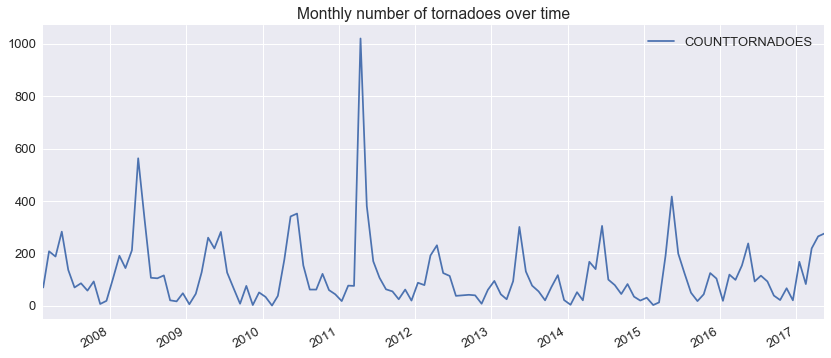

In [97]:
sns.set(font_scale=1.3)
count_per_month.plot(figsize=(14,6))
plt.title("Monthly number of tornadoes over time")
plt.show()

- It seems quite stationary in terms of mean, with a huge peek year in 2011.
- There is a clear yearly seasonability (it is well known tornadoes occur more between April and July)
- I was expecting a trend showing an increase of tornadoes over time, but it is not obvious.
- Let's try and see the same graph by taking the "strong" EF3 and higher tornadoes:

In [98]:
sql_query = """
SELECT "BEGIN_YEARMONTH", COUNT("BEGIN_YEARMONTH") as "COUNTTORNADOES"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702 
AND ("TOR_F_SCALE" = 'EF3' OR "TOR_F_SCALE" = 'EF4' OR "TOR_F_SCALE" = 'EF5')
GROUP BY "BEGIN_YEARMONTH"
ORDER BY "BEGIN_YEARMONTH" ASC
"""
count_per_month_EF3toEF5 = pd.read_sql(sql_query, engine_local)
print count_per_month_EF3toEF5.shape
count_per_month_EF3toEF5.head(2)

(80, 2)


,BEGIN_YEARMONTH,COUNTTORNADOES
0,200702,7
1,200703,15


In [99]:
count_per_month_EF3toEF5['YearMonth'] = count_per_month_EF3toEF5['BEGIN_YEARMONTH']\
                                        .map(lambda x: str(x)[:4]+'-'+str(x)[4:]+'-15')
count_per_month_EF3toEF5.drop(['BEGIN_YEARMONTH'], axis=1, inplace=True)
count_per_month_EF3toEF5['YearMonth'] = pd.to_datetime(count_per_month_EF3toEF5['YearMonth'])
count_per_month_EF3toEF5.set_index(['YearMonth'], inplace=True)
count_per_month_EF3toEF5.index.name = None
count_per_month_EF3toEF5.head()

,COUNTTORNADOES
2007-02-15,7
2007-03-15,15
2007-04-15,3
2007-05-15,8
2007-06-15,3


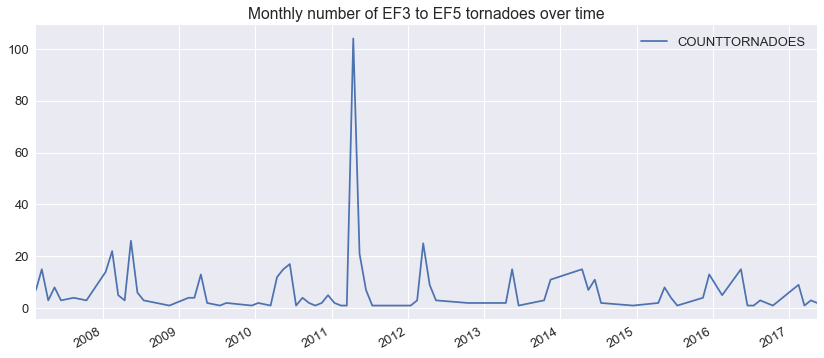

In [100]:
sns.set(font_scale=1.3)
count_per_month_EF3toEF5.plot(figsize=(14,6))
plt.title("Monthly number of EF3 to EF5 tornadoes over time")
plt.show()

Checking EF0 tornadoes:

In [101]:
sql_query = """
SELECT "BEGIN_YEARMONTH", COUNT("BEGIN_YEARMONTH") as "COUNTTORNADOES"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702 AND ("TOR_F_SCALE" = 'EF0' OR "TOR_F_SCALE" = 'EFU')
GROUP BY "BEGIN_YEARMONTH"
ORDER BY "BEGIN_YEARMONTH" ASC
"""
count_per_month_EF0 = pd.read_sql(sql_query, engine_local)
print count_per_month_EF0.shape
count_per_month_EF0.head(2)

(124, 2)


,BEGIN_YEARMONTH,COUNTTORNADOES
0,200702,23
1,200703,112


In [102]:
count_per_month_EF0['YearMonth'] = count_per_month_EF0['BEGIN_YEARMONTH']\
                                   .map(lambda x: str(x)[:4]+'-'+str(x)[4:]+'-15')
count_per_month_EF0.drop(['BEGIN_YEARMONTH'], axis=1, inplace=True)
count_per_month_EF0['YearMonth'] = pd.to_datetime(count_per_month_EF0['YearMonth'])
count_per_month_EF0.set_index(['YearMonth'], inplace=True)
count_per_month_EF0.index.name = None
count_per_month_EF0.head()

,COUNTTORNADOES
2007-02-15,23
2007-03-15,112
2007-04-15,108
2007-05-15,178
2007-06-15,106


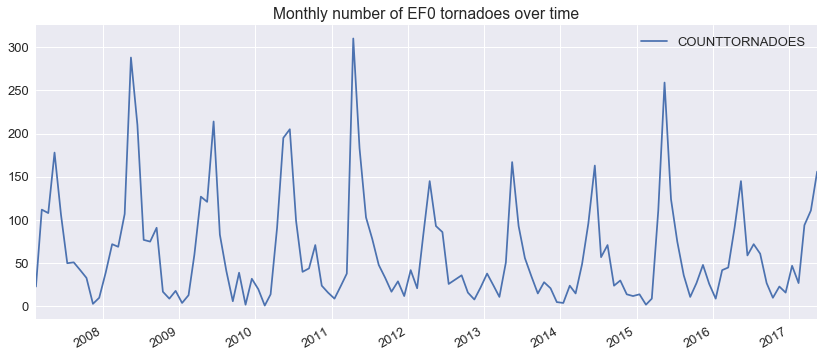

In [103]:
sns.set(font_scale=1.3)
count_per_month_EF0.plot(figsize=(14,6))
plt.title("Monthly number of EF0 tornadoes over time")
plt.show()

Checking EF0 and EF1 tornadoes:

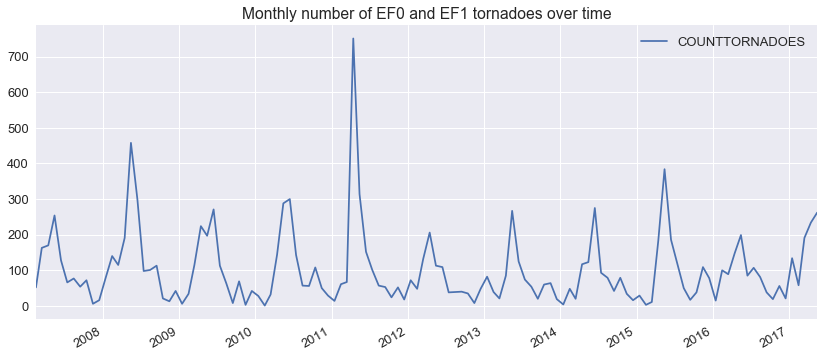

In [104]:
sql_query = """
SELECT "BEGIN_YEARMONTH", COUNT("BEGIN_YEARMONTH") as "COUNTTORNADOES"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702 
AND ("TOR_F_SCALE" = 'EF0' OR "TOR_F_SCALE" = 'EFU' OR "TOR_F_SCALE" = 'EF1')
GROUP BY "BEGIN_YEARMONTH"
ORDER BY "BEGIN_YEARMONTH" ASC
"""
count_per_month_EF0toEF1 = pd.read_sql(sql_query, engine_local)
count_per_month_EF0toEF1['YearMonth'] = count_per_month_EF0toEF1['BEGIN_YEARMONTH']\
                                        .map(lambda x: str(x)[:4]+'-'+str(x)[4:]+'-15')
count_per_month_EF0toEF1.drop(['BEGIN_YEARMONTH'], axis=1, inplace=True)
count_per_month_EF0toEF1['YearMonth'] = pd.to_datetime(count_per_month_EF0toEF1['YearMonth'])
count_per_month_EF0toEF1.set_index(['YearMonth'], inplace=True)
count_per_month_EF0toEF1.index.name = None
sns.set(font_scale=1.3)
count_per_month_EF0toEF1.plot(figsize=(14,6))
plt.title("Monthly number of EF0 and EF1 tornadoes over time")
plt.show()

Let's now check the evolution from the start of tornado officially counted (1950)

In [105]:
sql_query = """
SELECT "BEGIN_YEARMONTH", COUNT("BEGIN_YEARMONTH") as "COUNTTORNADOES"
FROM tornadoes_1950_mid2017 
GROUP BY "BEGIN_YEARMONTH"
ORDER BY "BEGIN_YEARMONTH" ASC
"""
count_per_month_since1950 = pd.read_sql(sql_query, engine_local)
count_per_month_since1950.head(2)

,BEGIN_YEARMONTH,COUNTTORNADOES
0,195001,8
1,195002,27


In [106]:
count_per_month_since1950.shape

(802, 2)

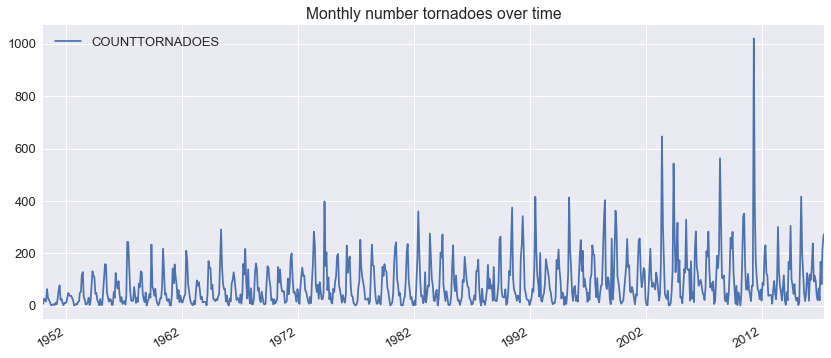

In [107]:
count_per_month_since1950 = pd.read_sql(sql_query, engine_local)
count_per_month_since1950['YearMonth'] = count_per_month_since1950['BEGIN_YEARMONTH']\
                                         .map(lambda x: str(x)[:4]+'-'+str(x)[4:]+'-15')
count_per_month_since1950.drop(['BEGIN_YEARMONTH'], axis=1, inplace=True)
count_per_month_since1950['YearMonth'] = pd.to_datetime(count_per_month_since1950['YearMonth'])
count_per_month_since1950.set_index(['YearMonth'], inplace=True)
count_per_month_since1950.index.name = None
sns.set(font_scale=1.3)
count_per_month_since1950.plot(figsize=(14,6))
plt.title("Monthly number tornadoes over time")
plt.show()

We should check only for the tornadoes happening in May, as it's the busiest month in terms of tornadoes

In [112]:
sql_query = """
SELECT "BEGIN_YEARMONTH", COUNT("BEGIN_YEARMONTH") as "COUNTTORNADOES"
FROM tornadoes_1950_mid2017 
WHERE "MONTH_NAME" = 'May'
GROUP BY "BEGIN_YEARMONTH"
ORDER BY "BEGIN_YEARMONTH" ASC
"""
count_per_month_Maysince1950 = pd.read_sql(sql_query, engine_local)
count_per_month_Maysince1950.head(2)

,BEGIN_YEARMONTH,COUNTTORNADOES
0,195005,64
1,195105,58


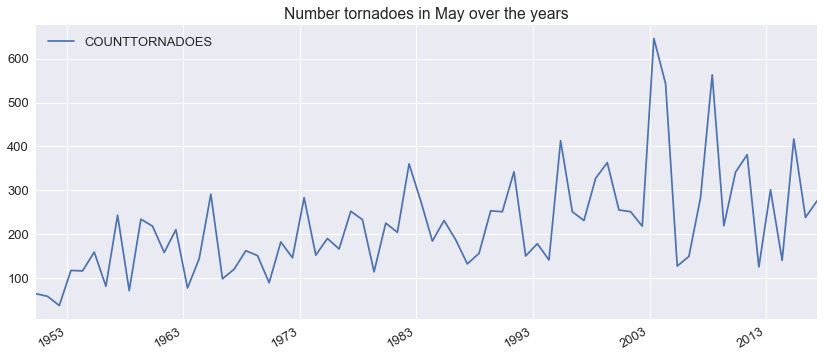

In [113]:
count_per_month_Maysince1950 = pd.read_sql(sql_query, engine_local)
count_per_month_Maysince1950['YearMonth'] = count_per_month_Maysince1950['BEGIN_YEARMONTH']\
                                            .map(lambda x: str(x)[:4]+'-'+str(x)[4:]+'-15')
count_per_month_Maysince1950.drop(['BEGIN_YEARMONTH'], axis=1, inplace=True)
count_per_month_Maysince1950['YearMonth'] = \
pd.to_datetime(count_per_month_Maysince1950['YearMonth'])

count_per_month_Maysince1950.set_index(['YearMonth'], inplace=True)
count_per_month_Maysince1950.index.name = None
sns.set(font_scale=1.3)
count_per_month_Maysince1950.plot(figsize=(14,6))
plt.title("Number tornadoes in May over the years")
plt.show()

For April, May and June:

In [120]:
sql_query = """
SELECT "YEAR", COUNT("YEAR") as "COUNTTORNADOES"
FROM tornadoes_1950_mid2017 
WHERE "MONTH_NAME" = 'April' OR "MONTH_NAME" = 'May' or "MONTH_NAME" = 'June'
GROUP BY "YEAR"
ORDER BY "YEAR" ASC
"""
count_per_month_AprilMayJunesince1950 = pd.read_sql(sql_query, engine_local)
count_per_month_AprilMayJunesince1950.head(2)

,YEAR,COUNTTORNADOES
0,1950,111
1,1951,163


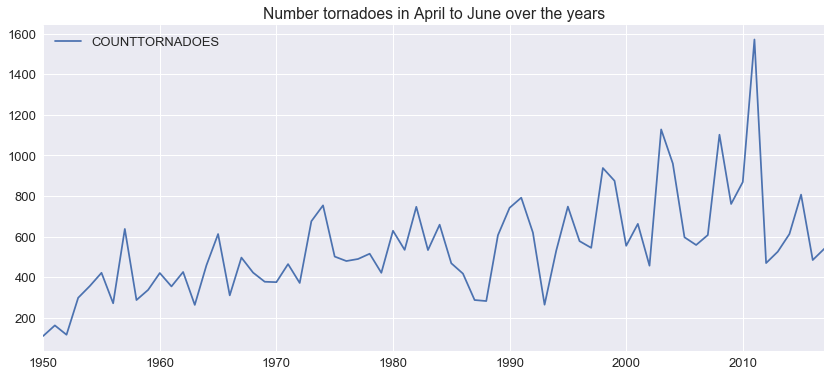

In [121]:
count_per_month_AprilMayJunesince1950['Year'] = count_per_month_AprilMayJunesince1950['YEAR']\
                                                .map(lambda x: str(x)+'-06-30')
count_per_month_AprilMayJunesince1950.drop(['YEAR'], axis=1, inplace=True)
count_per_month_AprilMayJunesince1950['Year'] = \
pd.to_datetime(count_per_month_AprilMayJunesince1950['Year'])

count_per_month_AprilMayJunesince1950.set_index(['Year'], inplace=True)
count_per_month_AprilMayJunesince1950.index.name = None
sns.set(font_scale=1.3)
count_per_month_AprilMayJunesince1950.plot(figsize=(14,6))
plt.title("Number tornadoes in April to June over the years")
plt.show()

## Conclusions from the TSA:
- Annual seasonability
- Increasing trend over the years: is it due to global warming yielding to more extreme weather or to the increased number of observers and material performance? I would suspect the last one :)

# Next things I want to try:
- Write a class including all my EDA, in order to use it efficiently into pipelines.
- Follow Juan's advice to upsample the strong tornadoes, to improve modeling.
- NLP: try and remove numbers and references to numbers from the vectorizer (how?).
- Incorporate the tokens from NLP into the feature matrix with tornado characteristics and rerun RF.
- Regression modelling: predict the total damage cost based on features including tornado strength. It could be a good target for insurance companies.
- Time series analysis: Try and define the trend over the years, and predict the number of tornadoes in 10 years.
- Start working in Tableau to make nice graphs and maybe try a time lapse as suggested by Christoph.